### Installs Required First Time: 

In [ ]:
# # First time need to download following libs: 
# !conda install -c conda-forge cvxpy
# !pip install riskfolio-lib
# !pip install quantstats
# !pip install yfinance
# !pip install dataframe-image

# # only if using extra libs & PyPortfolioOpt
# !pip install PyPortfolioOpt
# !pip install cvxportfolio
# !pip install ta
# !pip install pyfolio
# !pip install pyomo

## IMPORTS

In [129]:
# basic Python libs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import scipy
from scipy.stats import zscore
from collections import defaultdict
from IPython.display import display
import pickle
import dataframe_image as dfi
import warnings
warnings.filterwarnings("ignore")

# market data & optimizers 
import yfinance as yf
import cvxpy as cp
import riskfolio as rp
import quantstats as qs
from quantstats import stats as qss
from quantstats import reports, plots

# probably not needed since eventually did most on Riskfolio-Lib
# from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
# from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
# from pypfopt.efficient_frontier import EfficientFrontier 
# import pypfopt.objective_functions as ppo 

# # extra optimizer & financial libs 
# import cvxportfolio as cvx
# import ta
# import pyfolio as pf
# import pyomo 
# from pyomo.opt import SolverFactory
# from pyomo.environ import *


## DEFINING SECURITIES

### Exchange-traded funds (ETFs): 
1. GSG - iShares Commodities ETF
2. EEM - iShares Emerging Markets ETF
3. QQQ - Tech (Nasdaq 100) ETF
4. SPY - S&P 500 ETF
5. VNQ - Vanguard Real Estate ETF
6. BND - Vanguard Bond ETF $92B AUM
7. IGOV - iShares Int'l Govt Bonds ETF
8. GLD - SPDR Gold Trust ETF
9. XLF - SPDR Financials ETF
10. XLV - SPDR Healthcare ETF
11. XRT - SPDR S&P Retail ETF
12. FXI - iShares China ETF
13. BTC-USD - Bitcoin

### Individual Securities / Tickers (largest market cap companies):
1. AAPL - Apple 
2. TSLA - Tesla 
3. MSFT - Microsoft
4. GOOG - Alphabet fka Google 
5. AMZN - Amazon
6. META - Meta Platforms fka Facebook
7. V - Visa 
8. JPM - JP Morgan 
9. XOM - Exxon-Mobil 
10. WMT - Walmart
11. JNJ - Johnson & Johnson 
12. UNH - United Health
13. BRK-B - Berkshire Hathaway 
14. BABA - Alibaba 
15. 0700.HK - Tencent Holdings
16. MC.PA - LVMH (Louis Vuitton Moet Hennessy)
17. 2222.SR - Saudi Aramco - Dropped 

## yfinance stock price download:

In [4]:

tickers_sectors = ['GSG', 'EEM', 'QQQ', 'SPY', 'VNQ', 'BND', 'IGOV', 'GLD', 'XLV', 'XLF', 'XRT', 'FXI', 'BTC-USD']
tickers_companies = ['AAPL', 'TSLA', 'MSFT', 'GOOG', 'AMZN', 'META', 'V', 'JPM', 'XOM', 'WMT', 'JNJ', 'UNH', 'BRK-B', 'BABA', '0700.HK', 'MC.PA'] #'2222.SR']
tickers = ['GSG', 'EEM', 'QQQ', 'SPY', 'VNQ', 'BND', 'IGOV', 'GLD', 'XLV', 'XLF', 'XRT', 'FXI', 'BTC-USD', 'AAPL', 
           'TSLA', 'MSFT', 'GOOG', 'AMZN', 'META', 'V', 'JPM', 'XOM', 'WMT', 'JNJ', 'UNH', 'BRK-B', 'BABA', '0700.HK', 'MC.PA'] #'2222.SR'] 


# Function to get stock data
def get_stock_data(symbol):
    data = yf.download(symbol, start="2010-01-01", end="2015-01-01")
    return data['Adj Close']

def get_stock_data_year(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    return data['Adj Close']

def prices_to_df(tickers, start_date="2010-01-01", end_date="2015-01-01"):
    stock_data = pd.DataFrame()
    for symbol in tickers:
        stock_data[symbol] = get_stock_data_year(symbol, start_date, end_date)
    return stock_data

# Calculate log returns
def calc_indiv_returns(prices_df):
    returns = np.log(prices_df / prices_df.shift(1))
    returns.fillna(value=0, inplace=True)
    return returns

def calc_indiv_period_returns(price_return_dictionary, start_year='2010', end_year='2011'):
    
    prices_0 = price_return_dictionary[start_year]['prices'].iloc[0]
    prices_1 = price_return_dictionary[end_year]['prices'].iloc[0]
    indiv_period_returns = np.log(prices_1 / prices_0)
    indiv_period_returns.fillna(value=0, inplace=True)
    return indiv_period_returns

def calc_pf_returns(weights, returns):
    return weights @ returns 

In [3]:
## Generate price & returns data, historical 2010-2015 and forward by year 2015-2022
hist_prices = prices_to_df(tickers)
hist_returns = calc_indiv_returns(hist_prices)

# create daily price & returns data for 2015-2022 for each year, and then in trailing 5-year chunks

price_returns_dict = defaultdict(lambda: defaultdict(int)) 

# annual prices & returns 
for year in range(2015, 2023):
    price_data = prices_to_df(tickers, f"{year}-01-01", f"{year+1}-01-01")
    returns_data = calc_indiv_returns(price_data)
    price_returns_dict[f'{year}']['prices'] = price_data
    price_returns_dict[f'{year}']['returns'] = returns_data

# trailing 5yr prices & returns     
for year in range(2016, 2024):
    trailing_5y_period = f"{year-5} ⟺ {year}"
    price_data_5y = prices_to_df(tickers, f"{year-5}-01-01", f"{year}-01-01")
    returns_data_5y = calc_indiv_returns(price_data_5y)
    price_returns_dict[trailing_5y_period]['prices'] = price_data_5y
    price_returns_dict[trailing_5y_period]['returns'] = returns_data_5y

# 2018-on multiyr prices & returns 
for year in range(2018, 2023):
    period = f"{year} ⟺ 2023"
    price_data_period = prices_to_df(tickers, f"{year}-01-01", '2023-01-01')
    returns_data_period = calc_indiv_returns(price_data_period)
    price_returns_dict[period]['prices'] = price_data_period
    price_returns_dict[period]['returns'] = returns_data_period
    
# just for 1/1/2015 ⟺ 1/1/2023 prices & returns 
price_data_full_period = prices_to_df(tickers, "2015-01-01", '2023-01-01')
returns_data_full_period = calc_indiv_returns(price_data_full_period)
price_returns_dict["2015 ⟺ 2023"]['prices'] = price_data_full_period
price_returns_dict["2015 ⟺ 2023"]['returns'] = returns_data_full_period

print(f'Daily Price & Returns DataFrames Available by in Dictionary by Year: \n{list(price_returns_dict.keys())[:8]}\n\n and by 5-year chunks: \n {list(price_returns_dict.keys())[8:16]} \n\n and by multi-year chunks: \n {list(price_returns_dict.keys())[16:]} ') 
multiyr_periods_list = list(price_returns_dict.keys())[8:]
print(f'multiyr periods list: {multiyr_periods_list}')


Daily Price & Returns DataFrames Available by in Dictionary by Year: 
['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

 and by 5-year chunks: 
 ['2011 ⟺ 2016', '2012 ⟺ 2017', '2013 ⟺ 2018', '2014 ⟺ 2019', '2015 ⟺ 2020', '2016 ⟺ 2021', '2017 ⟺ 2022', '2018 ⟺ 2023'] 

 and by multi-year chunks: 
 ['2019 ⟺ 2023', '2020 ⟺ 2023', '2021 ⟺ 2023', '2022 ⟺ 2023'] 
multiyr periods list: ['2011 ⟺ 2016', '2012 ⟺ 2017', '2013 ⟺ 2018', '2014 ⟺ 2019', '2015 ⟺ 2020', '2016 ⟺ 2021', '2017 ⟺ 2022', '2018 ⟺ 2023', '2019 ⟺ 2023', '2020 ⟺ 2023', '2021 ⟺ 2023', '2022 ⟺ 2023']


## Pickle Prices & Returns Backup: 

#### Run this if need to restart so don't need to re-download all prices & returns data

In [5]:
price_returns_dict = defaultdict(lambda: defaultdict(int)) 
saved_price_returns_keys = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011 ⟺ 2016', '2012 ⟺ 2017', '2013 ⟺ 2018', '2014 ⟺ 2019', '2015 ⟺ 2020', '2016 ⟺ 2021', '2017 ⟺ 2022', '2018 ⟺ 2023', '2019 ⟺ 2023', '2020 ⟺ 2023', '2021 ⟺ 2023', '2022 ⟺ 2023', '2015 ⟺ 2023']

def pickle_backup():
    """
    Before restarting kernel, run this to download backup 
    """
     
    for key in price_returns_dict.keys():
        with open(f'price_return_dict{key}.pickle', 'wb') as f:
            pickle.dump(price_returns_dict[key], f)

def pickle_load():
    """
    Run this to retrieve from backup (using the saved dict keys)
    """
    
    for key in saved_price_returns_keys:
        file = open(f'price_return_dict{key}.pickle', 'rb')
        # dump information to that file
        price_returns_dict[key] = pickle.load(file)


# pickle_backup()
pickle_load()

hist_prices = prices_to_df(tickers)
hist_returns = calc_indiv_returns(hist_prices)
price_data_full_period = prices_to_df(tickers, "2015-01-01", '2023-01-01')
returns_data_full_period = calc_indiv_returns(price_data_full_period)
multiyr_periods_list = list(price_returns_dict.keys())[8:]

In [6]:
def returns_fwd(returns_next=price_returns_dict['2015 ⟺ 2020']['returns'], optimal_weights=None):
    optimal_returns_fwd = returns_next @ optimal_weights
    optimal_returns_fwd = optimal_returns_fwd[1:]
    # optimal_returns_fwd.rename(columns={"weights": "PF_Return"}, inplace=True)
    
    uniform_weights = np.full(len(tickers), 1/len(tickers))
    uniform_returns_fwd = returns_next @ uniform_weights
    uniform_returns_fwd = uniform_returns_fwd[1:]
    
    return optimal_returns_fwd, uniform_returns_fwd

## Price Correlation Heatmap Between All 26 Securities:

In [7]:
corr_df = hist_prices.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Individual Securities', width=1000, height=1100)
fig_corr.write_image("Correlation Heatmap - All 26 Securities.png")

fig_corr.show()

In [8]:
# other helper functions 

def prices_for_allocations(optimization_year='2015'):
    prices_year = price_returns_dict[optimization_year]['prices']
    prices_row_vector = prices_year.iloc[0]
    return prices_row_vector

def qs_perf(returns=None):
    pf_perf = {}
    pf_perf['returns'] = qss.comp(returns)
    metrics = ['volatility', 'sharpe', 'sortino', 'max_drawdown', 'var', 'cvar']
        
    pf_perf['volatility'] = qss.volatility(returns)
    pf_perf['sharpe'] = qss.sharpe(returns)
    pf_perf['sortino'] = qss.sortino(returns)
    pf_perf['max_drawdown'] = qss.max_drawdown(returns)
    pf_perf['VaR'] = qss.var(returns)
    pf_perf['CVaR'] = qss.cvar(returns)
    return pf_perf

# def calc_risk (pf_returns):
#     # VaR[t] = np.percentile(portfolio_returns_t[:, -1], 100 * alpha)
#     # CVaR[t] = (1 / (1 - alpha)) * cp.sum(cp.maximum(portfolio_returns_t[:, -1], VaR[t])) / (t+1)
#     # drawdown[:, t] = cp.maximum.accumulate(cp.cumsum(portfolio_returns_t, axis=0)) - cp.cumsum(portfolio_returns_t, axis=0)

# Riskfolio-Lib Optimizations:

In [60]:
rm_list = ['CVaR', 'MV', 'MAD', 'EVaR', 'MDD', 'RG', 'WR', 'MSV', 'CDaR', 'UCI', 'SLPM', 'FLPM', 'GMD', 'TG', 'EDaR', 'RLVaR']
# rp_opt_dict = defaultdict(lambda: defaultdict(int)) 

# opt_dict
# rp.plot_frontier(w_frontier=opt_dict['frontier'], mu=opt_dict['mu'], cov=opt_dict['cov'], 
#                  returns=opt_dict['returns'], rm=opt_dict['rm'], rf=opt_dict['rf'], alpha=0.05, w=optimal_weights)

In [51]:
def calculate_w(returns=hist_returns, rm='CVaR'): 
    """
    Available Options for Risk Measures: 
    'MV': Standard Deviation.
    'KT': Square Root of Kurtosis.
    'MAD': Mean Absolute Deviation.
    'GMD': Gini Mean Difference.
    'MSV': Semi Standard Deviation.
    'SKT': Square Root of Semi Kurtosis.
    'FLPM': First Lower Partial Moment (Omega Ratio).
    'SLPM': Second Lower Partial Moment (Sortino Ratio).
    'CVaR': Conditional Value at Risk.
    'TG': Tail Gini.
    'EVaR': Entropic Value at Risk.
    'RLVaR': Relativistic Value at Risk.
    'WR': Worst Realization (Minimax).
    'RG': Range of returns.
    'CVRG': CVaR range of returns.
    'TGRG': Tail Gini range of returns.
    'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
    'ADD': Average Drawdown of uncompounded cumulative returns.
    'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
    'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
    'RLDaR': Relativistic Drawdown at Risk of uncompounded cumulative returns.
    'UCI': Ulcer Index of uncompounded cumulative returns.
    """
    # from https://riskfolio-lib.readthedocs.io/en/latest/reports.html 
    #  NOTHING CALCULATES FORWARD RETURNS! 
    
    # Building the portfolio object
    # https://riskfolio-lib.readthedocs.io/en/latest/portfolio.html 
    port = rp.Portfolio(returns=returns)

    # Select method and estimate input parameters:
    method_mu='hist' # Method to estimate expected returns based on historical data. 
    method_cov='hist' # Method to estimate covariance matrix based on historical data.
    port.assets_stats (method_mu=method_mu, method_cov=method_cov, d=0.94)
    
    # Constraints configuration:
    # other constraint options include min return, max risk, turnover limits
    # pretty weak that can't add individual weight constraints or net exposure ranges 
    
    port.sht = True     # bool for allowing short positions (negative weights)
    port.uppersht = 1   # max sum of short weights 
    port.upperlng = 2 # max sum of long weights
    port.budget = 1   # port.upperlng - port.uppersht 

    # Estimate optimal portfolio:
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm 
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    # display(w)
    
    mu = port.mu
    cov = port.cov
    port_returns = port.returns
    
    # frontier = port.efficient_frontier(model=model, rm=rm, points=50, rf=rf, hist=hist)
    # optimization_dict = {"frontier": frontier, "mu": mu, "cov": cov, "returns": port_returns, "rm": rm, "rf": rf}
    # ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=port_returns, rm=rm, rf=rf, alpha=0.05, w=w)
    # ax1 = rp.plot_range(returns=port_returns, w=w, alpha=0.05)
    
    # return optimization_dict #ax
    return w

## Riskfolio CVaR Optimization Runs, 2015-2022:

In [11]:
rm = 'CVaR'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
cvar_mpo_weights_df = calculate_w(hist_returns, rm=rm)
cvar_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], cvar_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    cvar_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm=rm)
    cvar_mpo_weights_df = pd.concat([cvar_mpo_weights_df, cvar_mpo_weights_new], axis=1)
    cvar_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], cvar_mpo_weights_new)
    cvar_mpo_returns = pd.concat([cvar_mpo_returns, cvar_pf_returns])

cols = list(price_returns_dict.keys())[:8]
cvar_mpo_weights_df.columns = cols
cvar_mpo_returns.columns = ['Daily PF Returns']
display(cvar_mpo_weights_df)
display(cvar_mpo_returns)

daily_cumul_returns_fwd = (1 + cvar_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_cvar_mpo_cum = px.line(daily_cumul_returns_fwd, title="Cumulative Returns of MPO Optimized Portfolio Indexed to 100")
fig_cvar_mpo_cum.update_layout(showlegend=False)
fig_cvar_mpo_cum.show()
fig_cvar_mpo_cum.write_image("CVaR_MPO_cumulative_returns.png")



2015      2016      2017      2018          2019      2020  \
GSG     -0.070497 -0.108163 -0.111461 -0.098152 -1.144495e-01 -0.038460   
EEM     -0.302963 -0.377327 -0.221437 -0.127630 -7.723761e-02 -0.055025   
QQQ     -0.085094 -0.191130 -0.283149 -0.362938 -2.585069e-01 -0.494559   
SPY      0.338699  0.364488  0.433280  0.605243  3.318475e-01  0.240467   
VNQ      0.023073 -0.052624 -0.087141 -0.139328 -1.199217e-01 -0.079284   
BND      0.819120  0.836011  0.888919  0.868858  9.894544e-01  0.917912   
IGOV    -0.013911  0.107296  0.063194  0.041851  1.196888e-10 -0.049571   
GLD     -0.009595 -0.026573 -0.052160 -0.030671  2.323210e-02  0.084262   
XLV      0.121057  0.128881 -0.096824 -0.109664 -1.052922e-01 -0.032549   
XLF     -0.084449 -0.125901  0.116349  0.006709 -1.352026e-01 -0.135667   
FXI      0.087115  0.143995  0.072945  0.016535  9.893674e-03 -0.036121   
XRT      0.044900  0.002074  0.004477 -0.028209 -5.920618e-02 -0.025044   
BTC-USD -0.051898  0.006197  0.013191  0.028457  1.024414e-02  0.020122   
AAPL     0.085312  0.076884  0.059341  0.052807  3.401893e-02  0.073482   
TSLA     0.021655  0.032794  0.027475  0.016111  7.555909e-03  0.004099   
MSFT     0.010852  0.046478  0.068037  0.078221  1.109679e-01  0.076887   
GOOG    -0.045368  0.011474 -0.017127 -0.023227 -4.284712e-02 -0.000193   
AMZN    -0.008435  0.017159  0.034969  0.036965  5.937814e-02  0.125881   
META     0.010310  0.003796  0.015349  0.044622  2.259582e-02  0.026898   
V        0.058010  0.148817  0.057914  0.022671  1.703162e-02  0.095862   
JPM     -0.005767  0.032280 -0.003801  0.036649  1.873195e-01  0.241105   
XOM      0.024047  0.024837 -0.021820 -0.055079 -7.925570e-02 -0.038739   
WMT      0.032919 -0.016028 -0.036540 -0.015839 -4.528754e-03 -0.012130   
JNJ     -0.019267 -0.005359  0.087554  0.060305  3.244787e-02  0.019940   
UNH      0.030448  0.016540  0.041451  0.083996  1.640124e-01  0.073083   
BABA    -0.010272 -0.096893 -0.052988 -0.009263 -3.551719e-03 -0.002660   

             2021          2022  
GSG     -0.070592 -1.546854e-02  
EEM      0.020831 -8.961607e-02  
QQQ     -0.144698 -1.974574e-01  
SPY      0.005462 -5.024574e-01  
VNQ     -0.148162 -4.161103e-02  
BND      0.822625  8.377242e-01  
IGOV     0.067120  3.979090e-03  
GLD      0.063912  7.048038e-02  
XLV     -0.083736  2.067956e-01  
XLF     -0.145150 -3.943518e-02  
FXI     -0.109332 -4.712164e-02  
XRT     -0.109957  1.933529e-02  
BTC-USD  0.032813  2.751476e-02  
AAPL     0.068540  1.045123e-01  
TSLA     0.022086  3.889875e-02  
MSFT     0.077136  1.860692e-01  
GOOG    -0.074250  6.297241e-02  
AMZN     0.087938  7.256527e-02  
META    -0.011350 -2.597415e-02  
V        0.104764  3.540928e-02  
JPM      0.306108  1.990072e-01  
XOM     -0.102772 -4.085852e-02  
WMT      0.153226  1.244603e-01  
JNJ      0.035648 -1.911282e-10  
UNH      0.096246  1.027597e-02  
BABA     0.035544  8.116971e-12

Daily PF Returns
Date                        
2015-01-05          0.008043
2015-01-06          0.000810
2015-01-07          0.004843
2015-01-08          0.008239
2015-01-09         -0.002340
...                      ...
2022-12-23         -0.003877
2022-12-27         -0.015882
2022-12-28          0.002908
2022-12-29          0.004401
2022-12-30          0.000148

[2006 rows x 1 columns]

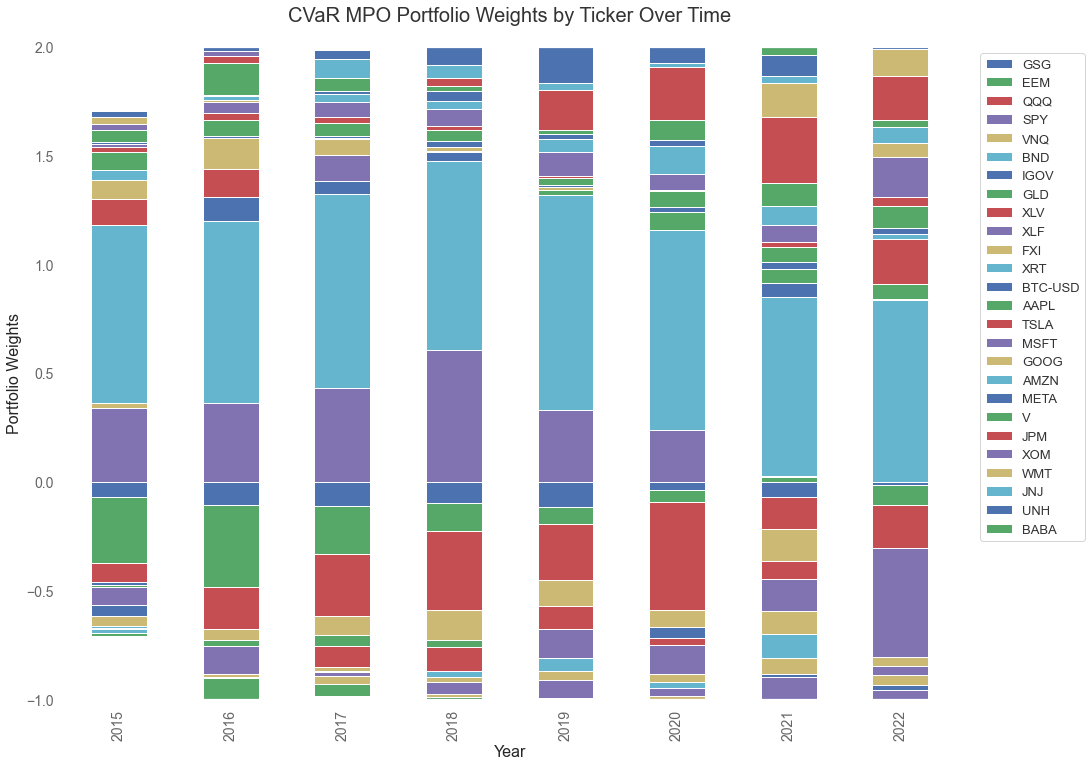

In [12]:
# Plot weights across time: 

# with pandas / plt 
cvar_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('CVaR MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_cvar_mpo_weights = px.bar(cvar_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_cvar_mpo_weights.update_layout(
    title = 'Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_cvar_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_cvar_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_cvar_mpo_weights.show()

fig_cvar_mpo_weights.write_image("CVaR_MPO_Weights.png")

### Riskfolio CVaR Optimizations - Performance Analysis:

In [13]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
cvar_spo_weights = calculate_w(hist_returns, rm=rm)
cvar_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, cvar_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo = qs.reports.metrics(cvar_mpo_returns, benchmark = cvar_spo_returns)
report_mpo_uniform = qs.reports.metrics(cvar_mpo_returns, benchmark = uniform_returns)
report_spo_uniform = qs.reports.metrics(cvar_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo, report_mpo_uniform, report_spo_uniform)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_cvar_mpo_daily = px.line(cvar_mpo_returns, title='Daily CVaR MPO Portfolio Returns - 2015-2022')
fig_cvar_mpo_daily.update_layout(showlegend=False)
fig_cvar_mpo_daily.show()

fig_cvar_spo_daily = px.line(cvar_spo_returns, title='Daily CVaR SPO Portfolio Returns - 2015-2022')
fig_cvar_spo_daily.update_layout(showlegend=False)
fig_cvar_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily CVaR Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_cvar_cumul_returns_mpo = (1 + cvar_mpo_returns).cumprod() * 100
fig2 = px.line(daily_cvar_cumul_returns_mpo, title="Cumulative Returns of CVaR MPO Portfolio Indexed to 100: 2015-2022")
fig2.update_layout(showlegend=False)
fig2.show()
# fig2.write_image("CVaR_MPO_cumulative_returns.png")

daily_cvar_cumul_returns_spo = (1 + cvar_spo_returns).cumprod() * 100
fig3 = px.line(daily_cvar_cumul_returns_spo, title="Cumulative Returns of CVaR SPO Portfolio Indexed to 100: 2015-2022")
fig3.update_layout(showlegend=False)
fig3.show()
fig3.write_image("CVaR_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
fig3 = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
fig3.update_layout(showlegend=False)
fig3.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   11.36%      30.75%
CAGR﹪              1.36%       3.41%

Sharpe              0.21        0.43
Prob. Sharpe Ratio  71.89%      88.63%
Sortino             0.29        0.61
Sortino/√2          0.21        0.43
Omega               1.04        1.04

Max Drawdown        -28.51%     -14.65%
Longest DD Days     724         1199

Gain/Pain Ratio     0.04        0.08
Gain/Pain (1M)      0.19        0.43

Payoff Ratio        0.99        0.99
Profit Factor       1.04        1.08
Common Sense Ratio  1.0         1.05
CPC Index           0.52        0.56
Tail Ratio          0.96        0.97
Outlier Win Ratio   3.59        3.32
Outlier Loss Ratio  3.7         3.22

MTD                 -3.51%      -2.88%
3M                  -1.99%      1.

None

None

None

## Riskfolio MV Optimization Runs, 2015-2022:

In [14]:
rm = 'MV'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
mv_mpo_weights_df = calculate_w(hist_returns, rm='MV')
mv_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], mv_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    mv_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='MV')
    mv_mpo_weights_df = pd.concat([mv_mpo_weights_df, mv_mpo_weights_new], axis=1)
    mv_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], mv_mpo_weights_new)
    mv_mpo_returns = pd.concat([mv_mpo_returns, mv_pf_returns])

cols = list(price_returns_dict.keys())[:8]
mv_mpo_weights_df.columns = cols
mv_mpo_returns.columns = ['Daily PF Returns']
display(mv_mpo_weights_df)
display(mv_mpo_returns)

mv_daily_cumul_returns_fwd = (1 + mv_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_mv_mpo_cum = px.line(mv_daily_cumul_returns_fwd, title="Cumulative Returns of Mean-Variance MPO Optimized Portfolio Indexed to 100")
fig_mv_mpo_cum.update_layout(showlegend=False)
fig_mv_mpo_cum.show()
fig_mv_mpo_cum.write_image("Mean-Variance_MPO_cumulative_returns.png")



2015      2016      2017      2018      2019          2020  \
GSG     -0.060247 -0.104017 -0.108663 -0.079281 -0.096777 -1.747752e-02   
EEM     -0.206616 -0.266351 -0.201374 -0.162053 -0.105532 -7.636545e-02   
QQQ     -0.112358 -0.310217 -0.209098 -0.343606 -0.303187 -3.687727e-01   
SPY      0.346776  0.454641  0.449825  0.633339  0.290045  4.096212e-01   
VNQ     -0.005218 -0.033509 -0.073057 -0.111630 -0.043823 -6.168148e-02   
BND      0.835096  0.872089  0.879864  0.793545  0.947789  8.900420e-01   
IGOV    -0.024432  0.016370  0.009355  0.041975 -0.061129 -5.743370e-02   
GLD      0.005826 -0.010382 -0.027596 -0.023567  0.048273  5.327373e-02   
XLV      0.054679  0.142369 -0.084740 -0.121774 -0.054112 -7.523522e-02   
XLF     -0.084920 -0.157718  0.101319 -0.026983 -0.152800 -2.052646e-01   
FXI      0.053772  0.079607  0.037827  0.026900  0.035534 -1.031465e-02   
XRT      0.059976  0.033125 -0.034279 -0.055263 -0.064492 -4.425483e-02   
BTC-USD -0.035331  0.000534  0.016299  0.031801  0.018899  1.812764e-02   
AAPL     0.052284  0.065521  0.038575  0.043439  0.048562  5.899170e-02   
TSLA     0.014236  0.025747  0.027245  0.026850  0.013484  4.247500e-03   
MSFT     0.004139  0.057132  0.041563  0.057897  0.102067  7.283254e-02   
GOOG    -0.014416  0.022666 -0.002555  0.002881 -0.037621 -5.719112e-07   
AMZN    -0.005434  0.017948  0.036247  0.030682  0.056669  7.477252e-02   
META     0.005733  0.005927  0.007118  0.040603  0.026741  1.507416e-02   
V        0.036175  0.101616  0.048818  0.029517  0.061013  4.691013e-02   
JPM      0.009422  0.052068  0.015460  0.057416  0.188906  2.429798e-01   
XOM      0.002893 -0.000597 -0.028637 -0.069391 -0.072432 -8.319582e-02   
WMT      0.002529 -0.064199 -0.053886 -0.006411 -0.004563  1.769821e-02   
JNJ      0.030457  0.017054  0.082173  0.078700  0.030387  1.459208e-02   
UNH      0.032464  0.035578  0.065615  0.089785  0.131621  6.902751e-02   
BABA     0.002515 -0.053002 -0.033416  0.014629 -0.003522  1.180582e-02   

                 2021          2022  
GSG     -2.928466e-02 -2.510982e-07  
EEM     -8.671583e-02 -1.666832e-01  
QQQ     -1.209370e-01 -2.819662e-01  
SPY      2.891541e-10 -1.776852e-01  
VNQ     -1.403937e-01 -1.018104e-01  
BND      5.237101e-01  5.122769e-01  
IGOV     2.646219e-01  2.062366e-01  
GLD      1.151913e-01  1.446296e-01  
XLV     -1.267713e-01  1.331449e-01  
XLF     -2.266324e-01 -1.008566e-01  
FXI     -3.876401e-02 -5.159475e-02  
XRT     -1.527817e-02  3.462778e-02  
BTC-USD  3.810041e-02  3.826213e-02  
AAPL     9.806530e-02  1.616188e-01  
TSLA     4.344396e-02  6.099551e-02  
MSFT     6.459137e-02  1.888050e-01  
GOOG    -6.930326e-02  6.366355e-02  
AMZN     9.105326e-02  7.161687e-02  
META    -2.545282e-02 -3.182348e-02  
V        1.123474e-01  4.332876e-02  
JPM      3.081997e-01  2.019928e-01  
XOM     -1.204654e-01 -8.674257e-02  
WMT      1.010615e-01  8.214298e-02  
JNJ      8.656290e-02 -1.256394e-06  
UNH      1.066358e-01  5.664828e-02  
BABA     4.641370e-02 -8.266600e-04

Daily PF Returns
Date                        
2015-01-05          0.005168
2015-01-06          0.000607
2015-01-07          0.003723
2015-01-08          0.006017
2015-01-09         -0.002388
...                      ...
2022-12-23         -0.002708
2022-12-27         -0.019362
2022-12-28          0.001906
2022-12-29          0.007687
2022-12-30          0.003394

[2006 rows x 1 columns]

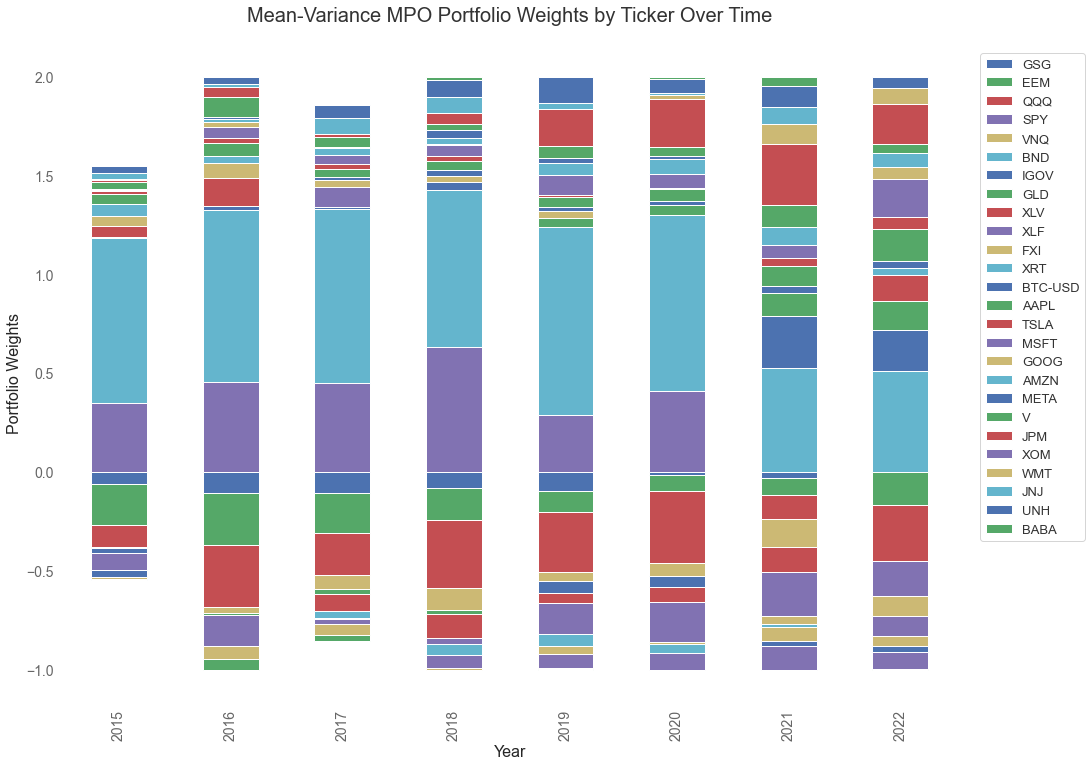

In [15]:
# Plot weights across time: 

# with pandas / plt 
mv_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Mean-Variance MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_mv_mpo_weights = px.bar(mv_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_mv_mpo_weights.update_layout(
    title = 'MV MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_mv_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_mv_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_mv_mpo_weights.show()

fig_mv_mpo_weights.write_image("MV_MPO_Weights.png")

### Riskfolio MV Optimizations - Performance Analysis:

In [21]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
mv_spo_weights = calculate_w(hist_returns, rm='MV')
mv_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, mv_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
mv_report_mpo_spo = qs.reports.metrics(mv_mpo_returns, benchmark = mv_spo_returns)
mv_report_mpo_uniform = qs.reports.metrics(mv_mpo_returns, benchmark = uniform_returns)
mv_report_spo_uniform = qs.reports.metrics(mv_spo_returns, benchmark = uniform_returns)
display(mv_report_mpo_spo, mv_report_mpo_uniform, mv_report_spo_uniform)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_mv_mpo_daily = px.line(mv_mpo_returns, title='Daily Mean-Variance MPO Portfolio Returns - 2015-2022')
fig_mv_mpo_daily.update_layout(showlegend=False)
fig_mv_mpo_daily.show()

fig_mv_spo_daily = px.line(mv_spo_returns, title='Daily Mean-Variance SPO Portfolio Returns - 2015-2022')
fig_mv_spo_daily.update_layout(showlegend=False)
fig_mv_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily Mean-Variance Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_mv_cumul_returns_mpo = (1 + mv_mpo_returns).cumprod() * 100
mv_cum_fig = px.line(daily_mv_cumul_returns_mpo, title="Cumulative Returns of Mean-Variance MPO Portfolio Indexed to 100: 2015-2022")
mv_cum_fig.update_layout(showlegend=False)
mv_cum_fig.show()
mv_cum_fig.write_image("MV_MPO_cumulative_returns.png")

daily_mv_cumul_returns_spo = (1 + mv_spo_returns).cumprod() * 100
mv_spo_cum_fig = px.line(daily_mv_cumul_returns_spo, title="Cumulative Returns of MV SPO Portfolio Indexed to 100: 2015-2022")
mv_spo_cum_fig.update_layout(showlegend=False)
mv_spo_cum_fig.show()
mv_spo_cum_fig.write_image("MV_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
mv_daily_uniform_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
mv_daily_uniform_cum.update_layout(showlegend=False)
mv_daily_uniform_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   11.76%      28.36%
CAGR﹪              1.4%        3.17%

Sharpe              0.21        0.46
Prob. Sharpe Ratio  71.99%      90.46%
Sortino             0.29        0.66
Sortino/√2          0.21        0.47
Omega               1.04        1.04

Max Drawdown        -33.34%     -15.39%
Longest DD Days     784         741

Gain/Pain Ratio     0.04        0.09
Gain/Pain (1M)      0.18        0.49

Payoff Ratio        0.9         0.94
Profit Factor       1.04        1.09
Common Sense Ratio  0.99        1.08
CPC Index           0.49        0.54
Tail Ratio          0.95        0.99
Outlier Win Ratio   3.77        4.22
Outlier Loss Ratio  3.56        4.0

MTD                 -5.31%      -2.33%
3M                  -4.18%      2.05

None

None

None

## Riskfolio Max-Drawdown Optimization Runs, 2015-2022:

In [16]:
# rm_list = ['CVaR', 'MV', 'MAD', 'EVaR', 'MDD', 'RG', 'WR']
rm = 'MDD'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
mdd_mpo_weights_df = calculate_w(hist_returns, rm='MDD')
mdd_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], mdd_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    mdd_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='MDD')
    mdd_mpo_weights_df = pd.concat([mdd_mpo_weights_df, mdd_mpo_weights_new], axis=1)
    mdd_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], mdd_mpo_weights_new)
    mdd_mpo_returns = pd.concat([mdd_mpo_returns, mdd_pf_returns])

cols = list(price_returns_dict.keys())[:8]
mdd_mpo_weights_df.columns = cols
mdd_mpo_returns.columns = ['Daily PF Returns']
display(mdd_mpo_weights_df)
display(mdd_mpo_returns)

daily_cumul_returns_fwd_mdd = (1 + mdd_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_mdd_mpo_cum = px.line(daily_cumul_returns_fwd_mdd, title="Cumulative Returns of MDD MPO Optimized Portfolio Indexed to 100")
fig_mdd_mpo_cum.update_layout(showlegend=False)
fig_mdd_mpo_cum.show()
fig_mdd_mpo_cum.write_image("MDD_MPO_cumulative_returns.png")



2015          2016          2017      2018      2019  \
GSG     -0.083549 -1.385768e-01 -9.839321e-02 -0.092073 -0.059500   
EEM     -0.174703 -2.151907e-01 -1.468416e-01 -0.039236 -0.047165   
QQQ     -0.347788 -1.782199e-01 -1.569882e-01 -0.453279 -0.223320   
SPY      0.741457  3.411058e-01  4.517823e-01  0.454982  0.170157   
VNQ     -0.004316 -7.582465e-02 -7.568698e-02 -0.209050 -0.093461   
BND      0.738196  8.837686e-01  9.730412e-01  0.929934  1.036724   
IGOV    -0.051077  6.859127e-02  1.424690e-02  0.048876 -0.093150   
GLD     -0.039619 -1.232821e-02 -4.822622e-02 -0.022965  0.036767   
XLV      0.009164 -1.974125e-02 -2.133647e-01 -0.048379 -0.030015   
XLF     -0.093900 -1.927852e-01  5.081449e-02  0.089358  0.039310   
FXI      0.039543  1.307380e-01  6.796442e-02  0.002871  0.007701   
XRT     -0.002022  1.597365e-02 -7.832975e-02  0.019188 -0.015475   
BTC-USD -0.008217  4.469608e-03  1.203640e-02  0.018502  0.004362   
AAPL     0.094451  6.505656e-02  6.216143e-02  0.051507  0.035643   
TSLA     0.024102  5.117788e-02  4.060092e-02  0.031600 -0.000082   
MSFT     0.040616  5.940282e-02 -1.316923e-02  0.094824  0.139326   
GOOG    -0.022878 -1.544390e-02 -4.376841e-03 -0.001082 -0.079641   
AMZN     0.006731 -1.356729e-02  3.050029e-02  0.032425  0.050853   
META    -0.002695 -1.941137e-02 -5.391329e-03  0.052369  0.020574   
V        0.044860  1.788825e-01  1.141361e-01  0.021557  0.044854   
JPM      0.027359  5.883270e-02 -8.336064e-13 -0.073016  0.034592   
XOM     -0.142419  2.766788e-11 -9.178131e-02 -0.037685 -0.082445   
WMT     -0.026820 -3.349630e-02 -1.002303e-02 -0.023234 -0.033293   
JNJ      0.011568  1.096978e-01  1.163972e-01  0.040117  0.069528   
UNH      0.046840  3.230281e-02  6.631835e-02  0.108828  0.084332   
BABA     0.175112 -8.541434e-02 -5.742757e-02  0.003062 -0.017179   

                 2020          2021          2022  
GSG     -1.989111e-02 -6.205773e-02 -1.608608e-02  
EEM     -7.601198e-02 -2.218489e-01 -1.699886e-02  
QQQ     -3.624786e-01  7.029748e-14 -2.276473e-13  
SPY      2.202433e-01 -1.087497e-12 -4.174503e-01  
VNQ     -6.383203e-02 -1.325845e-01 -1.343105e-01  
BND      1.036740e+00  5.204468e-01  3.137517e-01  
IGOV    -1.450896e-01  4.735315e-01  4.694395e-01  
GLD      7.945549e-02  1.296911e-12  1.714454e-01  
XLV     -6.951744e-02 -5.268363e-02  3.341744e-14  
XLF     -2.140952e-01 -2.305418e-01 -1.018145e-01  
FXI      5.085618e-03 -1.620480e-12 -1.911294e-01  
XRT      8.180436e-03 -1.012402e-01  4.671740e-13  
BTC-USD  1.043811e-02  1.756752e-02  3.087689e-02  
AAPL     5.136315e-02  3.112791e-02 -4.725146e-03  
TSLA     9.021752e-03  4.391143e-02  1.555946e-02  
MSFT     1.077738e-01  1.111354e-01  5.588202e-01  
GOOG    -5.562351e-03 -9.558171e-02  5.823684e-13  
AMZN     7.296071e-02  7.877654e-02  6.304607e-02  
META     9.910664e-03 -4.296709e-13 -5.477671e-02  
V        2.211327e-12  1.301332e-01  1.089583e-02  
JPM      2.697739e-01  3.917610e-01  2.145403e-01  
XOM     -4.352165e-02 -1.034615e-01 -5.015816e-02  
WMT      9.842939e-03  6.968549e-02 -5.240628e-13  
JNJ      3.734213e-02 -7.652303e-14 -1.255027e-02  
UNH      4.895304e-02  7.139013e-02  1.516246e-01  
BABA     2.291518e-02  6.053319e-02 -1.324439e-12

Daily PF Returns
Date                        
2015-01-05         -0.004760
2015-01-06          0.005286
2015-01-07          0.001137
2015-01-08          0.011852
2015-01-09         -0.005812
...                      ...
2022-12-23         -0.001393
2022-12-27         -0.018452
2022-12-28          0.006662
2022-12-29          0.005406
2022-12-30          0.004938

[2006 rows x 1 columns]

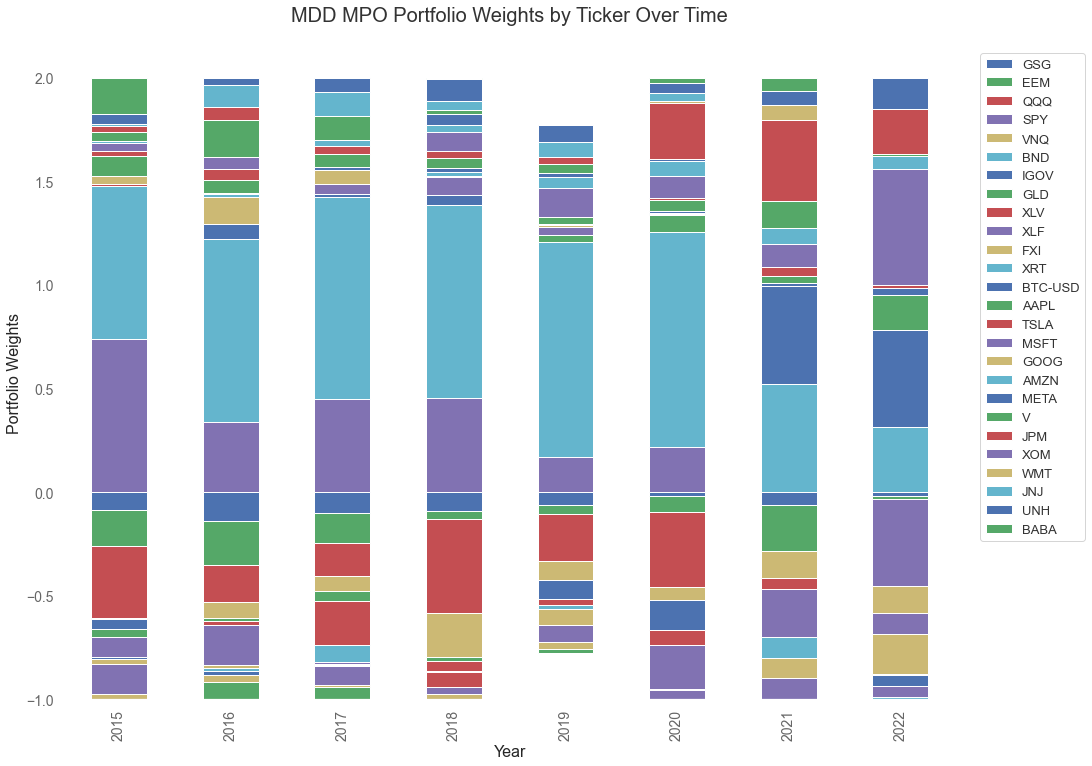

In [17]:
# Plot weights across time: 

# with pandas / plt 
mdd_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MDD MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_mdd_mpo_weights = px.bar(mdd_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_mdd_mpo_weights.update_layout(
    title = 'MDD MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_mdd_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_mdd_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_mdd_mpo_weights.show()

fig_mdd_mpo_weights.write_image("MDD_MPO_Weights.png")

### Riskfolio Max Drawdown Optimizations - Performance Analysis:

In [20]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
mdd_spo_weights = calculate_w(hist_returns, rm='MDD')
mdd_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, mdd_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo_mdd = qs.reports.metrics(mdd_mpo_returns, benchmark = mdd_spo_returns)
report_mpo_uniform_mdd = qs.reports.metrics(mdd_mpo_returns, benchmark = uniform_returns)
report_spo_uniform_mdd = qs.reports.metrics(mdd_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo_mdd, report_mpo_uniform_mdd, report_spo_uniform_mdd)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_mdd_mpo_daily = px.line(mdd_mpo_returns, title='Daily MDD MPO Portfolio Returns - 2015-2022')
fig_mdd_mpo_daily.update_layout(showlegend=False)
fig_mdd_mpo_daily.show()

fig_mdd_spo_daily = px.line(mdd_spo_returns, title='Daily MDD SPO Portfolio Returns - 2015-2022')
fig_mdd_spo_daily.update_layout(showlegend=False)
fig_mdd_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily MDD Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_mdd_cumul_returns_mpo = (1 + mdd_mpo_returns).cumprod() * 100
fig_cumul_mdd_mpo = px.line(daily_mdd_cumul_returns_mpo, title="Cumulative Returns of MDD MPO Portfolio Indexed to 100: 2015-2022")
fig_cumul_mdd_mpo.update_layout(showlegend=False)
fig_cumul_mdd_mpo.show()

daily_mdd_cumul_returns_spo = (1 + mdd_spo_returns).cumprod() * 100
fig_cum_mdd_spo = px.line(daily_mdd_cumul_returns_spo, title="Cumulative Returns of MDD SPO Portfolio Indexed to 100: 2015-2022")
fig_cum_mdd_spo.update_layout(showlegend=False)
fig_cum_mdd_spo.show()
fig_cum_mdd_spo.write_image("MDD_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
uniform_mdd_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
uniform_mdd_cum.update_layout(showlegend=False)
uniform_mdd_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   5.72%       48.4%
CAGR﹪              0.7%        5.07%

Sharpe              0.12        0.48
Prob. Sharpe Ratio  63.31%      91.14%
Sortino             0.17        0.7
Sortino/√2          0.12        0.49
Omega               1.02        1.02

Max Drawdown        -37.8%      -40.41%
Longest DD Days     780         808

Gain/Pain Ratio     0.02        0.09
Gain/Pain (1M)      0.11        0.46

Payoff Ratio        0.88        0.93
Profit Factor       1.02        1.09
Common Sense Ratio  0.92        1.03
CPC Index           0.47        0.54
Tail Ratio          0.9         0.95
Outlier Win Ratio   5.03        3.75
Outlier Loss Ratio  4.38        3.45

MTD                 -3.56%      -2.89%
3M                  0.63%       -0.01

None

None

None

## Riskfolio MAD Optimization Runs, 2015-2022:

In [18]:

rm = 'MAD'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
mad_mpo_weights_df = calculate_w(hist_returns, rm='MAD')
mad_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], mad_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    mad_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='MAD')
    mad_mpo_weights_df = pd.concat([mad_mpo_weights_df, mad_mpo_weights_new], axis=1)
    mad_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], mad_mpo_weights_new)
    mad_mpo_returns = pd.concat([mad_mpo_returns, mad_pf_returns])

cols = list(price_returns_dict.keys())[:8]
mad_mpo_weights_df.columns = cols
mad_mpo_returns.columns = ['Daily PF Returns']
display(mad_mpo_weights_df)
display(mad_mpo_returns)

daily_cumul_returns_fwd_mad = (1 + mad_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_mad_mpo_cum = px.line(daily_cumul_returns_fwd_mad, title="Cumulative Returns of MAD MPO Optimized Portfolio Indexed to 100")
fig_mad_mpo_cum.update_layout(showlegend=False)
fig_mad_mpo_cum.show()
fig_mad_mpo_cum.write_image("MAD_MPO_cumulative_returns.png")



2015      2016      2017      2018      2019      2020      2021  \
GSG     -0.057184 -0.096602 -0.115540 -0.069835 -0.095700 -0.022308 -0.025585   
EEM     -0.213027 -0.270704 -0.223304 -0.170220 -0.102664 -0.076637 -0.040228   
QQQ     -0.087396 -0.309024 -0.216428 -0.325895 -0.317929 -0.371249 -0.297798   
SPY      0.363198  0.464786  0.487092  0.645556  0.209081  0.304638  0.401906   
VNQ      0.001782 -0.031123 -0.051083 -0.101735 -0.008760 -0.041910 -0.105860   
BND      0.834048  0.840542  0.866033  0.771655  0.960821  0.920919  0.832392   
IGOV    -0.012919  0.017261  0.003945  0.040401 -0.109772 -0.096352 -0.027370   
GLD     -0.000215 -0.004737 -0.034024 -0.027331  0.059629  0.062703  0.066532   
XLV      0.049675  0.163849 -0.123190 -0.141954 -0.040823 -0.069015 -0.119594   
XLF     -0.114943 -0.166655  0.085967 -0.045273 -0.143593 -0.202515 -0.197451   
FXI      0.063195  0.077150  0.043544  0.029302  0.037828 -0.004046 -0.021319   
XRT      0.057483  0.045378 -0.044514 -0.044087 -0.052758 -0.033333  0.000915   
BTC-USD -0.067289  0.005470  0.020052  0.039128  0.019069  0.014670  0.022159   
AAPL     0.049554  0.064032  0.046140  0.042877  0.054268  0.061096  0.067915   
TSLA     0.008921  0.021950  0.026744  0.023184  0.008881  0.000248  0.027735   
MSFT    -0.001345  0.053603  0.040602  0.061122  0.139329  0.099855  0.065696   
GOOG    -0.016842  0.014914  0.002634  0.001451 -0.050720  0.000283 -0.039398   
AMZN    -0.008100  0.015684  0.029328  0.029065  0.068278  0.111164  0.054921   
META     0.005527  0.007221  0.007929  0.037239  0.028501  0.000181 -0.002565   
V        0.027788  0.100070  0.062187  0.036645  0.075642  0.048055  0.043816   
JPM      0.020392  0.061038  0.032242  0.063625  0.197002  0.272560  0.219238   
XOM      0.001624 -0.006252 -0.034340 -0.073669 -0.068968 -0.082635 -0.088541   
WMT      0.008010 -0.066747 -0.056577  0.001067 -0.000260  0.014520  0.056478   
JNJ      0.023921  0.011843  0.090233  0.078323  0.027857  0.014333  0.039170   
UNH      0.029548  0.035211  0.076987  0.079968  0.113815  0.064381  0.050791   
BABA     0.034593 -0.048156 -0.022659  0.019394 -0.008054  0.010394  0.016044   

             2022  
GSG      0.002835  
EEM     -0.029880  
QQQ     -0.290176  
SPY     -0.211979  
VNQ     -0.044185  
BND      0.767966  
IGOV    -0.043836  
GLD      0.097772  
XLV      0.142337  
XLF     -0.039455  
FXI     -0.057985  
XRT      0.038757  
BTC-USD  0.026914  
AAPL     0.124459  
TSLA     0.042382  
MSFT     0.170180  
GOOG     0.023332  
AMZN     0.059799  
META    -0.007326  
V        0.034472  
JPM      0.171622  
XOM     -0.068711  
WMT      0.077085  
JNJ     -0.024871  
UNH      0.040611  
BABA    -0.002119

Daily PF Returns
Date                        
2015-01-05          0.009036
2015-01-06         -0.000083
2015-01-07          0.002417
2015-01-08          0.008066
2015-01-09         -0.003462
...                      ...
2022-12-23         -0.003131
2022-12-27         -0.014328
2022-12-28          0.001619
2022-12-29          0.006106
2022-12-30         -0.000065

[2006 rows x 1 columns]

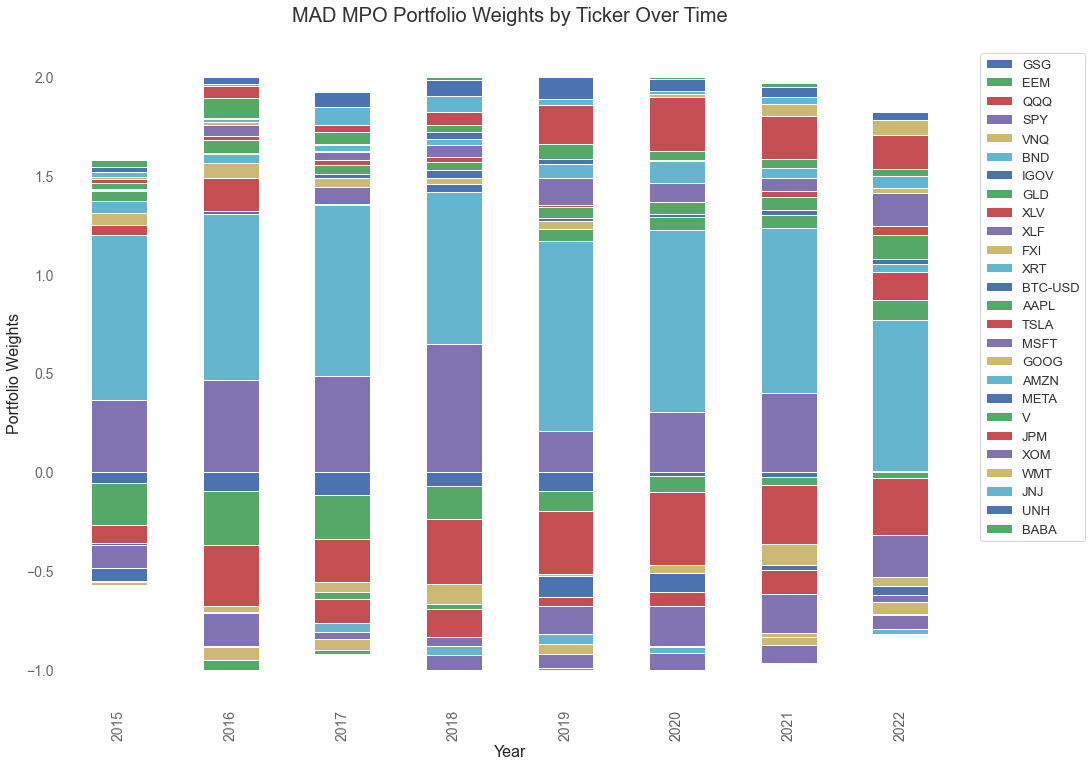

In [19]:
# Plot weights across time: 

# with pandas / plt 
mad_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MAD MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_mad_mpo_weights = px.bar(mad_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_mad_mpo_weights.update_layout(
    title = 'MAD MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_mad_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_mad_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_mad_mpo_weights.show()

fig_mad_mpo_weights.write_image("MAD_MPO_Weights.png")

### Riskfolio MAD (Mean Absolute Deviation) Optimizations - Performance Analysis:

In [22]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
mad_spo_weights = calculate_w(hist_returns, rm='MAD')
mad_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, mad_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo_mad = qs.reports.metrics(mad_mpo_returns, benchmark = mad_spo_returns)
report_mpo_uniform_mad = qs.reports.metrics(mad_mpo_returns, benchmark = uniform_returns)
report_spo_uniform_mad = qs.reports.metrics(mad_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo_mad, report_mpo_uniform_mad, report_spo_uniform_mad)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_mad_mpo_daily = px.line(mad_mpo_returns, title='Daily MAD MPO Portfolio Returns - 2015-2022')
fig_mad_mpo_daily.update_layout(showlegend=False)
fig_mad_mpo_daily.show()

fig_mad_spo_daily = px.line(mad_spo_returns, title='Daily MAD SPO Portfolio Returns - 2015-2022')
fig_mad_spo_daily.update_layout(showlegend=False)
fig_mad_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily MAD Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_mad_cumul_returns_mpo = (1 + mad_mpo_returns).cumprod() * 100
fig_cumul_mad_mpo = px.line(daily_mad_cumul_returns_mpo, title="Cumulative Returns of MAD MPO Portfolio Indexed to 100: 2015-2022")
fig_cumul_mad_mpo.update_layout(showlegend=False)
fig_cumul_mad_mpo.show()

daily_mad_cumul_returns_spo = (1 + mad_spo_returns).cumprod() * 100
fig_cum_mad_spo = px.line(daily_mad_cumul_returns_spo, title="Cumulative Returns of MAD SPO Portfolio Indexed to 100: 2015-2022")
fig_cum_mad_spo.update_layout(showlegend=False)
fig_cum_mad_spo.show()
fig_cum_mad_spo.write_image("MAD_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
uniform_mad_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
uniform_mad_cum.update_layout(showlegend=False)
uniform_mad_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   29.33%      7.91%
CAGR﹪              3.27%       0.96%

Sharpe              0.44        0.16
Prob. Sharpe Ratio  89.59%      67.16%
Sortino             0.65        0.22
Sortino/√2          0.46        0.16
Omega               1.09        1.09

Max Drawdown        -22.51%     -21.43%
Longest DD Days     780         1316

Gain/Pain Ratio     0.09        0.03
Gain/Pain (1M)      0.46        0.13

Payoff Ratio        0.95        0.92
Profit Factor       1.09        1.03
Common Sense Ratio  1.1         0.97
CPC Index           0.54        0.49
Tail Ratio          1.02        0.94
Outlier Win Ratio   3.71        3.42
Outlier Loss Ratio  3.6         3.23

MTD                 -3.62%      -2.02%
3M                  -2.07%      3.3

None

None

None

## Riskfolio FLPM (First Lower Partial Moment) Optimization Runs, 2015-2022:

In [68]:
rm = 'FLPM'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
flpm_mpo_weights_df = calculate_w(hist_returns, rm='FLPM')
flpm_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], flpm_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    flpm_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='FLPM')
    flpm_mpo_weights_df = pd.concat([flpm_mpo_weights_df, flpm_mpo_weights_new], axis=1)
    flpm_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], flpm_mpo_weights_new)
    flpm_mpo_returns = pd.concat([flpm_mpo_returns, flpm_pf_returns])

cols = list(price_returns_dict.keys())[:8]
flpm_mpo_weights_df.columns = cols
flpm_mpo_returns.columns = ['Daily PF Returns']
display(flpm_mpo_weights_df)
display(flpm_mpo_returns)

daily_cumul_returns_fwd_flpm = (1 + flpm_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_flpm_mpo_cum = px.line(daily_cumul_returns_fwd_flpm, title="Cumulative Returns of FLPM MPO Optimized Portfolio Indexed to 100")
fig_flpm_mpo_cum.update_layout(showlegend=False)
fig_flpm_mpo_cum.show()
fig_flpm_mpo_cum.write_image("FLPM_MPO_cumulative_returns.png")



2015      2016      2017      2018      2019          2020  \
GSG     -0.058725 -0.102026 -0.116518 -0.068586 -0.095077 -2.057694e-02   
EEM     -0.234324 -0.269586 -0.215154 -0.179849 -0.107720 -6.734567e-02   
QQQ     -0.136692 -0.306207 -0.210857 -0.322651 -0.330834 -4.081567e-01   
SPY      0.407600  0.509505  0.430457  0.587933  0.212030  3.226337e-01   
VNQ     -0.007229 -0.022534 -0.050606 -0.092615 -0.021159 -4.304847e-02   
BND      0.809846  0.850585  0.868771  0.771447  0.950657  9.104934e-01   
IGOV     0.000693  0.024892 -0.001539  0.029856 -0.086877 -8.863502e-02   
GLD      0.011857 -0.010725 -0.021819 -0.020111  0.065503  5.965012e-02   
XLV      0.073956  0.130251 -0.122945 -0.160367 -0.043465 -6.153432e-02   
XLF     -0.100265 -0.170987  0.090356 -0.032233 -0.146000 -1.965137e-01   
FXI      0.066038  0.075941  0.041288  0.035652  0.039962 -2.453031e-13   
XRT      0.053491  0.027190 -0.043619 -0.041468 -0.056843 -3.358760e-02   
BTC-USD -0.058323  0.002044  0.018715  0.038933  0.020326  1.485551e-02   
AAPL     0.048379  0.057911  0.043811  0.040755  0.051343  5.998062e-02   
TSLA     0.011621  0.021758  0.023845  0.023314  0.011013 -3.718065e-04   
MSFT    -0.001915  0.057862  0.049605  0.071631  0.140790  9.898533e-02   
GOOG    -0.011973  0.013757 -0.000607  0.000717 -0.044284  8.729749e-13   
AMZN    -0.000840  0.015453  0.034116  0.036716  0.070835  1.198595e-01   
META     0.004254  0.005859  0.011579  0.035942  0.022239  1.570137e-03   
V        0.031158  0.103785  0.055919  0.039905  0.080863  5.143740e-02   
JPM      0.021118  0.054740  0.029377  0.075301  0.199533  2.648651e-01   
XOM     -0.006107 -0.000899 -0.023551 -0.069039 -0.056203 -8.022984e-02   
WMT      0.013027 -0.069218 -0.046151  0.001277  0.003002  8.863973e-03   
JNJ      0.022126  0.017499  0.104122  0.097793  0.016067  1.347940e-02   
UNH      0.018866  0.030966  0.078682  0.086895  0.115838  6.653181e-02   
BABA     0.022363 -0.047818 -0.027278  0.012850 -0.011537  6.794029e-03   

             2021      2022  
GSG     -0.033116 -0.003768  
EEM     -0.031173 -0.019157  
QQQ     -0.268392 -0.263030  
SPY      0.429879 -0.252718  
VNQ     -0.112366 -0.031994  
BND      0.832075  0.802039  
IGOV    -0.026855 -0.086975  
GLD      0.075326  0.107336  
XLV     -0.122307  0.122910  
XLF     -0.202593 -0.024546  
FXI     -0.030162 -0.062814  
XRT     -0.008715  0.036413  
BTC-USD  0.022962  0.024609  
AAPL     0.055820  0.123077  
TSLA     0.024509  0.043262  
MSFT     0.066386  0.170707  
GOOG    -0.044862  0.029098  
AMZN     0.051025  0.049211  
META    -0.002326 -0.007053  
V        0.032286  0.026994  
JPM      0.217079  0.172218  
XOM     -0.088492 -0.067987  
WMT      0.057141  0.078164  
JNJ      0.033907 -0.013946  
UNH      0.053499  0.050955  
BABA     0.019465 -0.003005

Daily PF Returns
Date                        
2015-01-05          0.007977
2015-01-06         -0.000094
2015-01-07          0.002680
2015-01-08          0.006852
2015-01-09         -0.003328
...                      ...
2022-12-23         -0.003297
2022-12-27         -0.014470
2022-12-28          0.001906
2022-12-29          0.006018
2022-12-30         -0.000254

[2006 rows x 1 columns]

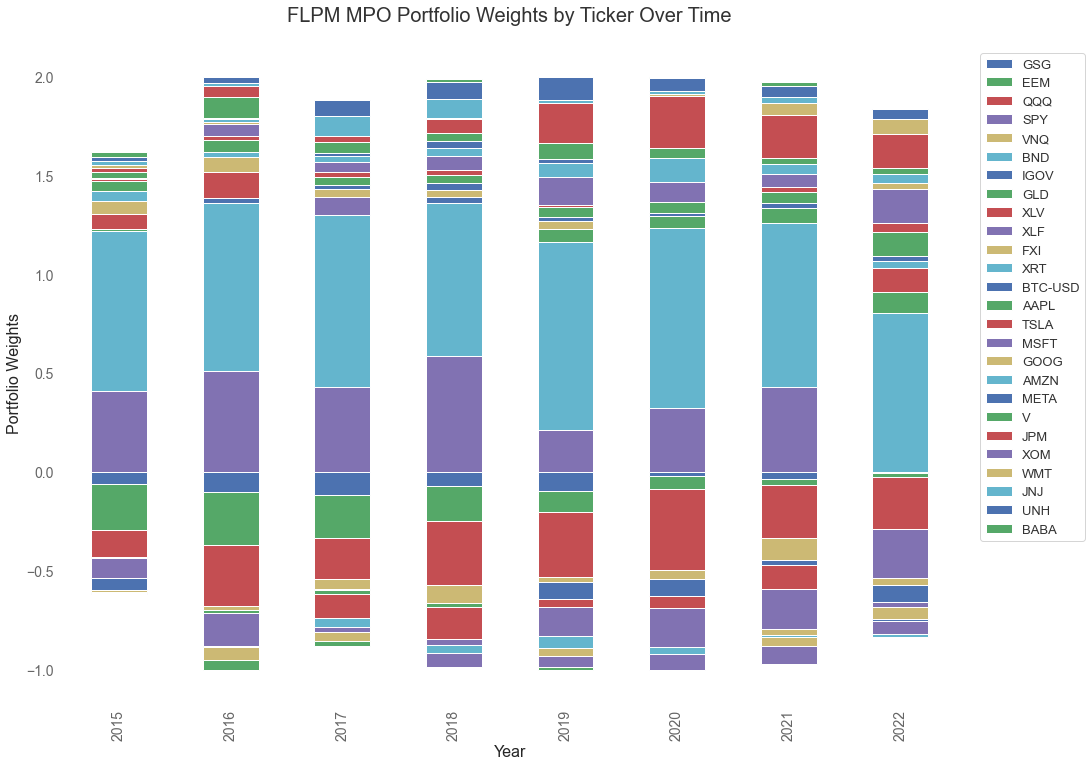

In [69]:
# Plot weights across time: 

# with pandas / plt 
flpm_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('FLPM MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_flpm_mpo_weights = px.bar(flpm_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_flpm_mpo_weights.update_layout(
    title = 'FLPM MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_flpm_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_flpm_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_flpm_mpo_weights.show()

fig_flpm_mpo_weights.write_image("FLPM_MPO_Weights.png")

### Riskfolio FLPM Optimizations - Performance Analysis:

In [70]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
flpm_spo_weights = calculate_w(hist_returns, rm='FLPM')
flpm_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, flpm_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo_flpm = qs.reports.metrics(flpm_mpo_returns, benchmark = flpm_spo_returns)
report_mpo_uniform_flpm = qs.reports.metrics(flpm_mpo_returns, benchmark = uniform_returns)
report_spo_uniform_flpm = qs.reports.metrics(flpm_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo_flpm, report_mpo_uniform_flpm, report_spo_uniform_flpm)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_flpm_mpo_daily = px.line(flpm_mpo_returns, title='Daily FLPM MPO Portfolio Returns - 2015-2022')
fig_flpm_mpo_daily.update_layout(showlegend=False)
fig_flpm_mpo_daily.show()

fig_flpm_spo_daily = px.line(flpm_spo_returns, title='Daily FLPM SPO Portfolio Returns - 2015-2022')
fig_flpm_spo_daily.update_layout(showlegend=False)
fig_flpm_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily FLPM Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_flpm_cumul_returns_mpo = (1 + flpm_mpo_returns).cumprod() * 100
fig_cumul_flpm_mpo = px.line(daily_flpm_cumul_returns_mpo, title="Cumulative Returns of FLPM MPO Portfolio Indexed to 100: 2015-2022")
fig_cumul_flpm_mpo.update_layout(showlegend=False)
fig_cumul_flpm_mpo.show()

daily_flpm_cumul_returns_spo = (1 + flpm_spo_returns).cumprod() * 100
fig_cum_flpm_spo = px.line(daily_flpm_cumul_returns_spo, title="Cumulative Returns of FLPM SPO Portfolio Indexed to 100: 2015-2022")
fig_cum_flpm_spo.update_layout(showlegend=False)
fig_cum_flpm_spo.show()
fig_cum_flpm_spo.write_image("FLPM_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
uniform_flpm_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
uniform_flpm_cum.update_layout(showlegend=False)
uniform_flpm_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   28.84%      13.62%
CAGR﹪              3.22%       1.61%

Sharpe              0.44        0.24
Prob. Sharpe Ratio  89.45%      75.43%
Sortino             0.64        0.35
Sortino/√2          0.45        0.25
Omega               1.09        1.09

Max Drawdown        -22.62%     -19.76%
Longest DD Days     780         926

Gain/Pain Ratio     0.09        0.04
Gain/Pain (1M)      0.46        0.22

Payoff Ratio        0.96        0.94
Profit Factor       1.09        1.04
Common Sense Ratio  1.09        0.96
CPC Index           0.55        0.51
Tail Ratio          1.01        0.92
Outlier Win Ratio   3.63        3.5
Outlier Loss Ratio  3.59        3.35

MTD                 -3.64%      -2.08%
3M                  -2.14%      3.14

None

None

None

## Riskfolio UCI (Ulcer Index) Optimization Runs, 2015-2022:


In [73]:

rm = 'UCI'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
uci_mpo_weights_df = calculate_w(hist_returns, rm='UCI')
uci_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], uci_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    uci_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='UCI')
    uci_mpo_weights_df = pd.concat([uci_mpo_weights_df, uci_mpo_weights_new], axis=1)
    uci_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], uci_mpo_weights_new)
    uci_mpo_returns = pd.concat([uci_mpo_returns, uci_pf_returns])

cols = list(price_returns_dict.keys())[:8]
uci_mpo_weights_df.columns = cols
uci_mpo_returns.columns = ['Daily PF Returns']
display(uci_mpo_weights_df)
display(uci_mpo_returns)

daily_cumul_returns_fwd_uci = (1 + uci_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_uci_mpo_cum = px.line(daily_cumul_returns_fwd_uci, title="Cumulative Returns of UCI MPO Optimized Portfolio Indexed to 100")
fig_uci_mpo_cum.update_layout(showlegend=False)
fig_uci_mpo_cum.show()
fig_uci_mpo_cum.write_image("UCI_MPO_cumulative_returns.png")



2015          2016      2017          2018      2019      2020  \
GSG     -0.060682 -8.063098e-02 -0.052155 -7.312652e-02 -0.067851 -0.024285   
EEM     -0.200996 -2.000231e-01 -0.172618 -5.358894e-02 -0.050381 -0.037756   
QQQ     -0.264871 -2.664783e-01 -0.052577 -3.797848e-01 -0.348163 -0.328771   
SPY      0.763592  5.393492e-01  0.407532  6.776943e-01  0.425322  0.225473   
VNQ     -0.061030 -5.911196e-02 -0.059188 -1.817440e-01 -0.112909 -0.062802   
BND      0.866033  9.298064e-01  0.929646  9.657897e-01  0.956697  0.958696   
IGOV    -0.051008  9.101113e-03 -0.019598 -5.757051e-02 -0.064435 -0.132096   
GLD     -0.018617 -5.240015e-02 -0.037778 -2.590366e-02  0.013566  0.092806   
XLV      0.018876  3.791598e-02 -0.148286 -9.573722e-02 -0.039233 -0.112282   
XLF     -0.098683 -1.543440e-01  0.016907 -2.235928e-02 -0.055649 -0.223572   
FXI      0.072198  9.151673e-02  0.064654  2.312264e-09  0.009037 -0.029521   
XRT     -0.003344  1.783561e-10 -0.091569 -3.935148e-02 -0.045650 -0.009443   
BTC-USD -0.068319  1.512812e-02  0.012229  2.410681e-02  0.007987  0.005541   
AAPL     0.059285  5.631012e-02  0.028160  3.614311e-02  0.052734  0.027242   
TSLA     0.018634  2.822238e-02  0.020374  2.088182e-02  0.002394  0.002308   
MSFT     0.015853  6.224348e-02  0.026380  6.728906e-02  0.160479  0.149573   
GOOG    -0.031232 -9.708144e-03 -0.021938 -1.571352e-02 -0.107825  0.000548   
AMZN     0.011408  1.493829e-02  0.020299  2.007919e-02  0.048213  0.086975   
META    -0.002575 -1.133324e-02 -0.004271  6.197527e-02  0.052849  0.016539   
V        0.034028  1.282208e-01  0.093655  1.059519e-02  0.065703  0.014578   
JPM      0.016679  4.373128e-02  0.006306 -3.634849e-03  0.054465  0.277483   
XOM     -0.064818 -1.448807e-03 -0.041750 -5.148521e-02 -0.077930 -0.033397   
WMT     -0.031339 -5.600025e-02 -0.004041  4.151716e-03 -0.006618  0.021207   
JNJ     -0.003349  1.296259e-02  0.066623  1.515388e-02  0.016956  0.032946   
UNH      0.014964  3.055357e-02  0.064991  9.613991e-02  0.133598  0.088085   
BABA     0.069311 -1.085210e-01 -0.051986 -2.592045e-09 -0.023354 -0.006074   

                 2021          2022  
GSG     -5.016922e-02 -3.337522e-03  
EEM     -5.782503e-02 -2.395137e-03  
QQQ      4.081391e-10  8.191323e-02  
SPY      6.455745e-02 -6.305207e-01  
VNQ     -1.107905e-01 -4.089125e-03  
BND      8.783529e-01  8.597903e-01  
IGOV    -1.858435e-02 -3.690752e-02  
GLD      8.182998e-02  4.932042e-02  
XLV     -2.115531e-01  7.393157e-02  
XLF     -3.124459e-01 -1.371756e-01  
FXI     -5.212363e-02 -5.899931e-02  
XRT     -8.783329e-10  2.772742e-02  
BTC-USD  1.144071e-02  1.801679e-02  
AAPL    -7.116064e-03  1.577723e-02  
TSLA     2.237108e-02  7.790860e-03  
MSFT     1.633927e-01  3.053688e-01  
GOOG    -1.113507e-01  7.002023e-03  
AMZN     2.516217e-02  2.713833e-02  
META     8.766934e-03 -1.676699e-02  
V        6.022502e-02  5.396041e-02  
JPM      3.901699e-01  3.361602e-01  
XOM     -6.804156e-02 -6.695995e-02  
WMT      7.691296e-02  4.244991e-02  
JNJ      7.434097e-02  5.779004e-11  
UNH      1.126588e-01  9.365255e-02  
BABA     2.981835e-02 -4.284817e-02

Daily PF Returns
Date                        
2015-01-05          0.005342
2015-01-06         -0.001069
2015-01-07          0.000585
2015-01-08          0.009785
2015-01-09         -0.004701
...                      ...
2022-12-23         -0.002989
2022-12-27         -0.013722
2022-12-28          0.005858
2022-12-29          0.003233
2022-12-30          0.000308

[2006 rows x 1 columns]

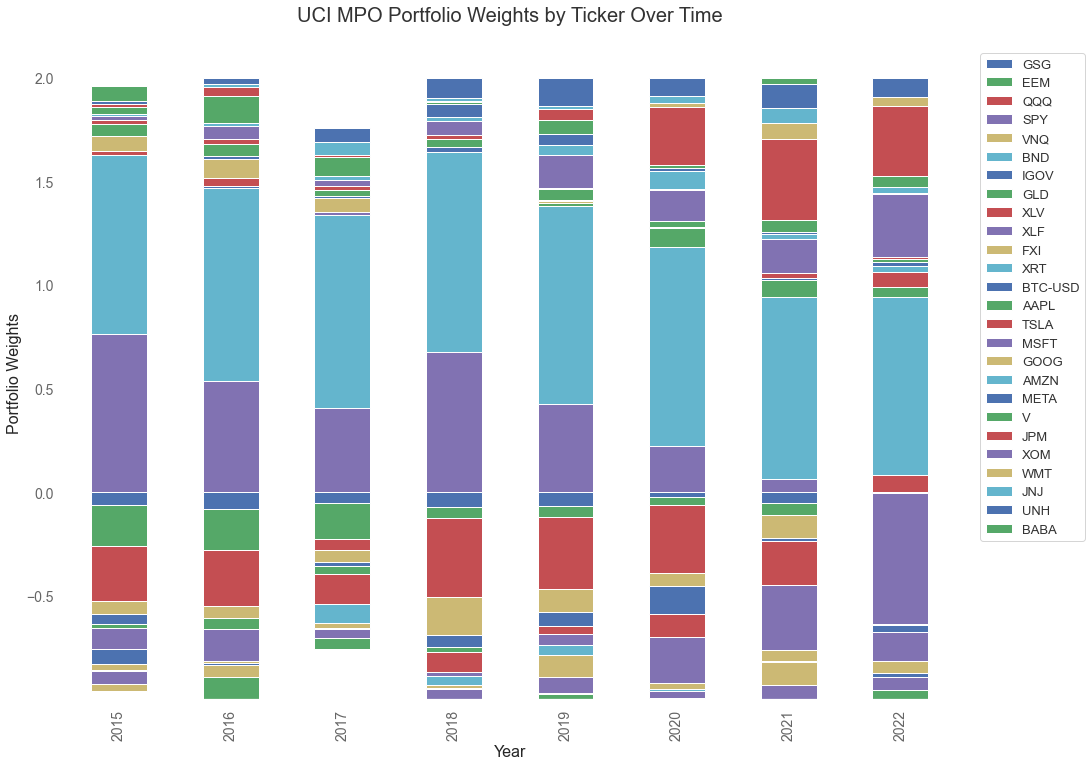

In [74]:
# Plot weights across time: 

# with pandas / plt 
uci_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('UCI MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_uci_mpo_weights = px.bar(uci_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_uci_mpo_weights.update_layout(
    title = 'UCI MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_uci_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_uci_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_uci_mpo_weights.show()

fig_uci_mpo_weights.write_image("UCI_MPO_Weights.png")

### Riskfolio UCI Optimizations - Performance Analysis:

In [75]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
uci_spo_weights = calculate_w(hist_returns, rm='UCI')
uci_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, uci_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo_uci = qs.reports.metrics(uci_mpo_returns, benchmark = uci_spo_returns)
report_mpo_uniform_uci = qs.reports.metrics(uci_mpo_returns, benchmark = uniform_returns)
report_spo_uniform_uci = qs.reports.metrics(uci_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo_uci, report_mpo_uniform_uci, report_spo_uniform_uci)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_uci_mpo_daily = px.line(uci_mpo_returns, title='Daily UCI MPO Portfolio Returns - 2015-2022')
fig_uci_mpo_daily.update_layout(showlegend=False)
fig_uci_mpo_daily.show()

fig_uci_spo_daily = px.line(uci_spo_returns, title='Daily UCI SPO Portfolio Returns - 2015-2022')
fig_uci_spo_daily.update_layout(showlegend=False)
fig_uci_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily UCI Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_uci_cumul_returns_mpo = (1 + uci_mpo_returns).cumprod() * 100
fig_cumul_uci_mpo = px.line(daily_uci_cumul_returns_mpo, title="Cumulative Returns of UCI MPO Portfolio Indexed to 100: 2015-2022")
fig_cumul_uci_mpo.update_layout(showlegend=False)
fig_cumul_uci_mpo.show()

daily_uci_cumul_returns_spo = (1 + uci_spo_returns).cumprod() * 100
fig_cum_uci_spo = px.line(daily_uci_cumul_returns_spo, title="Cumulative Returns of UCI SPO Portfolio Indexed to 100: 2015-2022")
fig_cum_uci_spo.update_layout(showlegend=False)
fig_cum_uci_spo.show()
fig_cum_uci_spo.write_image("UCI_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
uniform_uci_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
uniform_uci_cum.update_layout(showlegend=False)
uniform_uci_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   22.34%      11.84%
CAGR﹪              2.56%       1.41%

Sharpe              0.35        0.2
Prob. Sharpe Ratio  83.92%      71.35%
Sortino             0.5         0.29
Sortino/√2          0.36        0.2
Omega               1.07        1.07

Max Drawdown        -28.58%     -28.93%
Longest DD Days     784         1121

Gain/Pain Ratio     0.07        0.04
Gain/Pain (1M)      0.37        0.17

Payoff Ratio        0.99        0.96
Profit Factor       1.07        1.04
Common Sense Ratio  1.07        1.0
CPC Index           0.55        0.51
Tail Ratio          1.0         0.96
Outlier Win Ratio   4.07        3.39
Outlier Loss Ratio  4.05        3.35

MTD                 -2.13%      -2.21%
3M                  2.41%       1.98%

None

None

None

## Riskfolio CDaR (Conditional Drawdown at Risk) Optimization Runs, 2015-2022:

In [76]:

rm = 'CDaR'
full_holding_period = list(price_returns_dict.keys())[-1] # 1/1/2015-1/1/2023

#initial optimization 1/1/2015
cdar_mpo_weights_df = calculate_w(hist_returns, rm='CDaR')
cdar_mpo_returns, _ = returns_fwd(price_returns_dict['2015']['returns'], cdar_mpo_weights_df)

# 2016-2022 optimizatiosn & daily portfolio return calcs
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']    
    cdar_mpo_weights_new = calculate_w(daily_returns_last_5yr, rm='CDaR')
    cdar_mpo_weights_df = pd.concat([cdar_mpo_weights_df, cdar_mpo_weights_new], axis=1)
    cdar_pf_returns, _ = returns_fwd(price_returns_dict[f'{year}']['returns'], cdar_mpo_weights_new)
    cdar_mpo_returns = pd.concat([cdar_mpo_returns, cdar_pf_returns])

cols = list(price_returns_dict.keys())[:8]
cdar_mpo_weights_df.columns = cols
cdar_mpo_returns.columns = ['Daily PF Returns']
display(cdar_mpo_weights_df)
display(cdar_mpo_returns)

daily_cumul_returns_fwd_cdar = (1 + cdar_mpo_returns).cumprod() * 100 # compounding, indexed at 100 
fig_cdar_mpo_cum = px.line(daily_cumul_returns_fwd_cdar, title="Cumulative Returns of CDaR MPO Optimized Portfolio Indexed to 100")
fig_cdar_mpo_cum.update_layout(showlegend=False)
fig_cdar_mpo_cum.show()
fig_cdar_mpo_cum.write_image("CDaR_MPO_cumulative_returns.png")



2015          2016      2017          2018      2019      2020  \
GSG     -0.065149 -8.634157e-02 -0.054291 -7.441471e-02 -0.067826 -0.028556   
EEM     -0.171714 -1.562340e-01 -0.146923 -1.793158e-02  0.000661 -0.030792   
QQQ     -0.333491 -2.980692e-01 -0.195325 -4.719711e-01 -0.404540 -0.281832   
SPY      0.789561  5.029111e-01  0.559218  6.127200e-01  0.363564  0.275721   
VNQ     -0.051952 -8.255135e-02 -0.090719 -2.257506e-01 -0.116976 -0.045612   
BND      0.797971  9.553538e-01  0.946575  9.446294e-01  1.036909  1.000759   
IGOV    -0.042972 -1.052833e-02 -0.000806 -1.186252e-02 -0.087692 -0.157283   
GLD     -0.031899 -4.515993e-02 -0.058090 -2.640369e-02 -0.000113  0.086320   
XLV      0.031051  3.976842e-02 -0.146985 -3.949253e-02 -0.001404 -0.138120   
XLF     -0.113635 -1.498923e-01 -0.056549 -1.052115e-11 -0.034763 -0.221943   
FXI      0.056471  7.249546e-02  0.060868 -2.284538e-02 -0.025778 -0.022340   
XRT     -0.001811 -1.653200e-12 -0.088121 -2.407830e-02 -0.032284 -0.021223   
BTC-USD -0.023812  1.836380e-02  0.010075  2.106503e-02  0.005552  0.006827   
AAPL     0.073780  6.683140e-02  0.052619  4.942615e-02  0.056423  0.026065   
TSLA     0.016832  2.633088e-02  0.030238  2.191679e-02  0.002805  0.006401   
MSFT     0.024534  8.245972e-02  0.028199  9.551957e-02  0.164859  0.101582   
GOOG    -0.029922  7.268567e-12 -0.015946 -3.303646e-03 -0.099596 -0.005675   
AMZN     0.013766  3.201676e-10  0.033552  1.852703e-02  0.057210  0.080295   
META     0.002005 -2.048907e-03 -0.002876  7.420096e-02  0.056320  0.008209   
V        0.042467  1.549339e-01  0.099013  1.359133e-02  0.052251  0.000563   
JPM      0.025179  3.387633e-02  0.036084 -2.544383e-02  0.067365  0.270741   
XOM     -0.083972  1.136442e-02 -0.084153 -5.211844e-02 -0.109482 -0.036336   
WMT     -0.030348 -5.214992e-02  0.003824  1.341641e-02 -0.002705  0.011826   
JNJ     -0.019322  8.872678e-03  0.067147  1.664974e-02  0.034850  0.052717   
UNH      0.013545  2.643803e-02  0.072588  1.183376e-01  0.101230  0.071974   
BABA     0.112836 -1.170245e-01 -0.059217 -4.383611e-03 -0.016842 -0.010288   

                 2021          2022  
GSG     -6.043812e-02  1.621411e-03  
EEM     -2.652509e-02 -8.076249e-02  
QQQ     -3.963535e-13  1.582560e-01  
SPY      8.172457e-14 -7.292669e-01  
VNQ     -1.052646e-01 -1.563280e-03  
BND      8.849480e-01  9.387264e-01  
IGOV     2.975162e-13 -4.904187e-02  
GLD      7.639240e-02  2.803781e-02  
XLV     -2.020996e-01  9.509616e-02  
XLF     -3.303015e-01 -3.800198e-12  
FXI     -7.924966e-02 -3.303427e-02  
XRT     -3.061865e-03  4.877436e-03  
BTC-USD  1.883445e-02  2.732444e-02  
AAPL    -8.805957e-03 -4.285641e-14  
TSLA     2.024450e-02  2.362358e-03  
MSFT     1.899478e-01  2.972444e-01  
GOOG    -1.215578e-01 -2.076395e-13  
AMZN     2.171252e-02  3.061939e-02  
META     8.330362e-03 -1.742213e-02  
V        4.793566e-02  5.760813e-02  
JPM      4.149969e-01  2.577128e-01  
XOM     -6.269589e-02 -6.995211e-02  
WMT      7.725816e-02  2.240775e-02  
JNJ      7.688237e-02 -5.381626e-13  
UNH      1.113752e-01  7.810554e-02  
BABA     5.114168e-02 -1.895693e-02

Daily PF Returns
Date                        
2015-01-05         -0.002239
2015-01-06          0.002165
2015-01-07          0.001245
2015-01-08          0.009743
2015-01-09         -0.004469
...                      ...
2022-12-23         -0.004465
2022-12-27         -0.013107
2022-12-28          0.005744
2022-12-29          0.003262
2022-12-30         -0.000789

[2006 rows x 1 columns]

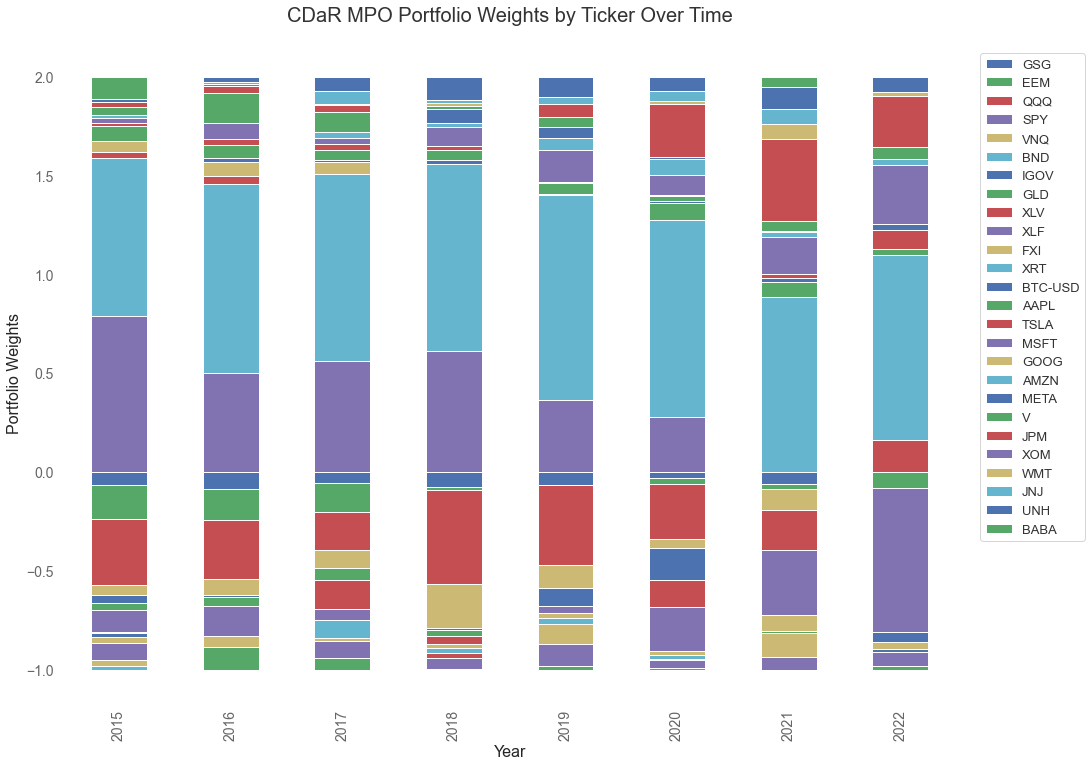

In [77]:
# Plot weights across time: 

# with pandas / plt 
cdar_mpo_weights_df.transpose().plot.bar(stacked=True, figsize=(16,12))
plt.xlabel('Year', fontsize=16, y=1.04)
plt.ylabel('Portfolio Weights', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('CDaR MPO Portfolio Weights by Ticker Over Time', fontsize=20, y=1.03)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
plt.show()

# with Plotly Express: 
fig_cdar_mpo_weights = px.bar(cdar_mpo_weights_df.transpose(), barmode='stack', color_continuous_scale=px.colors.diverging.BrBG)

fig_cdar_mpo_weights.update_layout(
    title = 'CDaR MPO Portfolio Weights by Ticker by Year',
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Portfolio Weight',
    legend_title='Ticker',
    yaxis=dict(range=[-1, 1.5], dtick=0.25),
    showlegend=True,
    height=1000,
)

fig_cdar_mpo_weights.update_xaxes(showgrid=True, showline=True)
fig_cdar_mpo_weights.update_yaxes(showgrid=True, showline=True)

fig_cdar_mpo_weights.show()

fig_cdar_mpo_weights.write_image("CDaR_MPO_Weights.png")

### Riskfolio CDaR Optimizations - Performance Analysis:

In [78]:
# daily returns for SPO & equal-weighted portfolios 2015-2022: 
cdar_spo_weights = calculate_w(hist_returns, rm='CDaR')
cdar_spo_returns, uniform_returns = returns_fwd(returns_data_full_period, cdar_spo_weights)

# Generating Quantstats Portfolio Comparison Reports: 
report_mpo_spo_cdar = qs.reports.metrics(cdar_mpo_returns, benchmark = cdar_spo_returns)
report_mpo_uniform_cdar = qs.reports.metrics(cdar_mpo_returns, benchmark = uniform_returns)
report_spo_uniform_cdar = qs.reports.metrics(cdar_spo_returns, benchmark = uniform_returns)
display(report_mpo_spo_cdar, report_mpo_uniform_cdar, report_spo_uniform_cdar)    

# Generate daily portfolio returns charts for the 3 portfolio approaches    
fig_cdar_mpo_daily = px.line(uci_mpo_returns, title='Daily CDaR MPO Portfolio Returns - 2015-2022')
fig_cdar_mpo_daily.update_layout(showlegend=False)
fig_cdar_mpo_daily.show()

fig_cdar_spo_daily = px.line(uci_spo_returns, title='Daily CDaR SPO Portfolio Returns - 2015-2022')
fig_cdar_spo_daily.update_layout(showlegend=False)
fig_cdar_spo_daily.show()

fig_uniform_daily = px.line(uniform_returns, title='Daily CDaR Uniform Portfolio Returns - 2015-2022')
fig_uniform_daily.update_layout(showlegend=False)
fig_uniform_daily.show()

# Cumulative portfolio return charts for the 3 approaches: 
daily_cdar_cumul_returns_mpo = (1 + cdar_mpo_returns).cumprod() * 100
fig_cumul_cdar_mpo = px.line(daily_cdar_cumul_returns_mpo, title="Cumulative Returns of CDaR MPO Portfolio Indexed to 100: 2015-2022")
fig_cumul_cdar_mpo.update_layout(showlegend=False)
fig_cumul_cdar_mpo.show()

daily_cdar_cumul_returns_spo = (1 + cdar_spo_returns).cumprod() * 100
fig_cum_cdar_spo = px.line(daily_cdar_cumul_returns_spo, title="Cumulative Returns of CDaR SPO Portfolio Indexed to 100: 2015-2022")
fig_cum_cdar_spo.update_layout(showlegend=False)
fig_cum_cdar_spo.show()
fig_cum_cdar_spo.write_image("CDaR_SPO_cumulative_returns.png")

daily_cumul_returns_uniform = (1 + uniform_returns).cumprod() * 100
uniform_cdar_cum = px.line(daily_cumul_returns_uniform, title="Cumulative Returns of Uniform Portfolio Indexed to 100: 2015-2022")
uniform_cdar_cum.update_layout(showlegend=False)
uniform_cdar_cum.show()

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   22.48%      31.47%
CAGR﹪              2.57%       3.48%

Sharpe              0.36        0.41
Prob. Sharpe Ratio  84.32%      87.8%
Sortino             0.51        0.6
Sortino/√2          0.36        0.42
Omega               1.07        1.07

Max Drawdown        -29.19%     -32.59%
Longest DD Days     724         808

Gain/Pain Ratio     0.07        0.08
Gain/Pain (1M)      0.36        0.4

Payoff Ratio        0.96        0.94
Profit Factor       1.07        1.08
Common Sense Ratio  1.05        1.02
CPC Index           0.54        0.53
Tail Ratio          0.98        0.95
Outlier Win Ratio   4.33        3.61
Outlier Loss Ratio  4.04        3.36

MTD                 -1.73%      -2.2%
3M                  1.27%       1.51%
6

None

None

None

# Portfolio & Risk-Measure Comparison Analysis: 

In [84]:
def calc_uniform_stats(returns=uniform_returns, days=252):
    port_stats_dict['uniform']['pf_annualized_return'] = np.mean(returns) * days
    port_stats_dict['uniform']['pf_cumulative_return'] = ((1 + returns).cumprod() - 1).iloc[-1]
    port_stats_dict['uniform']['pf_annualized_volatility'] = returns.std() * np.sqrt(days)
    port_stats_dict['uniform']['pf_cumulative_volatility'] = returns.std() * np.sqrt(days * 8)
    port_stats_dict['uniform']['pf_Sharpe_annual'] = ((np.mean(returns) * days) - 0.02) / (returns.std() * np.sqrt(days))
    cum_compounded_rf = (1.02 ** 8) - 1
    port_stats_dict['uniform']['pf_Sharpe_cumulative'] = ((((1 + returns).cumprod() - 1).iloc[-1]) - cum_compounded_rf) / (returns.std() * np.sqrt(days * 8))

def calc_pf_returns(returns=cvar_mpo_returns, days=252):
    avg_annual = (np.mean(returns) * days).get(0)
    cum_returns = ((1 + returns).cumprod() - 1).iloc[-1].get(0)
    return avg_annual, cum_returns

def calc_pf_volatility(returns=cvar_mpo_returns, days=252):
    avg_annual = (returns.std() * np.sqrt(days)).get(0)
    total_period_vol = (returns.std() * np.sqrt(days * 8)).get(0)
    return avg_annual, total_period_vol

def calc_pf_sharpe(returns, volatility, risk_free_rate):
    return (returns - risk_free_rate) / volatility

# weights_list = 
port_stats_dict = defaultdict(lambda: defaultdict(int)) 
portfolio_list = ['cvar_mpo', 'cvar_spo', 'mv_mpo', 'mv_spo', 'mdd_mpo', 'mdd_spo', 'mad_mpo', 'mad_spo', 'flpm_mpo', 'flpm_spo', 
                  'uci_mpo', 'uci_spo', 'cdar_mpo', 'cdar_spo']
returns_list = [cvar_mpo_returns, cvar_spo_returns, mv_mpo_returns, mv_spo_returns, mdd_mpo_returns, mdd_spo_returns, 
                mad_mpo_returns, mad_spo_returns, flpm_mpo_returns, flpm_spo_returns, uci_mpo_returns, uci_spo_returns,
                cdar_mpo_returns, cdar_spo_returns]
for i, portfolio in enumerate(portfolio_list):
    ann_return, cum_return = calc_pf_returns(returns_list[i])
    ann_vol, cum_vol = calc_pf_volatility(returns_list[i])
    port_stats_dict[portfolio]['pf_annualized_return'] = ann_return
    port_stats_dict[portfolio]['pf_cumulative_return'] = cum_return
    port_stats_dict[portfolio]['pf_annualized_volatility'] = ann_vol
    port_stats_dict[portfolio]['pf_cumulative_volatility'] = cum_vol
    port_stats_dict[portfolio]['pf_Sharpe_annual'] = calc_pf_sharpe(ann_return, ann_vol, risk_free_rate=0.02)
    cumulative_compounded_rf = (1.02 ** 8) - 1
    port_stats_dict[portfolio]['pf_Sharpe_cumulative'] = calc_pf_sharpe(cum_return, cum_vol, risk_free_rate=cumulative_compounded_rf)
    
calc_uniform_stats()

# volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

In [85]:
perf_df = pd.DataFrame.from_dict(port_stats_dict, orient='index')
perf_df.index.name = 'Portfolio'
display(perf_df)
# list(port_stats_dict.items())

pf_annualized_return  pf_cumulative_return  \
Portfolio                                               
cvar_mpo               0.016902              0.113564   
cvar_spo               0.038380              0.317972   
mv_mpo                 0.017619              0.117619   
mv_spo                 0.034565              0.290251   
mdd_mpo                0.011680              0.057150   
mdd_spo                0.055835              0.476947   
mad_mpo                0.035522              0.293279   
mad_spo                0.014004              0.088835   
flpm_mpo               0.034986              0.288418   
flpm_spo               0.020027              0.145240   
uci_mpo                0.028692              0.223433   
uci_spo                0.018800              0.124356   
cdar_mpo               0.028724              0.224782   
cdar_spo               0.038374              0.311755   
uniform                0.109894              1.134201   

           pf_annualized_volatility  pf_cumulative_volatility  \
Portfolio                                                       
cvar_mpo                   0.082377                  0.232997   
cvar_spo                   0.087386                  0.247164   
mv_mpo                     0.085505                  0.241844   
mv_spo                     0.072969                  0.206387   
mdd_mpo                    0.097003                  0.274365   
mdd_spo                    0.118540                  0.335282   
mad_mpo                    0.080269                  0.227036   
mad_spo                    0.081885                  0.231606   
flpm_mpo                   0.079468                  0.224769   
flpm_spo                   0.078135                  0.221000   
uci_mpo                    0.082041                  0.232047   
uci_spo                    0.090915                  0.257146   
cdar_mpo                   0.080716                  0.228300   
cdar_spo                   0.093890                  0.265560   
uniform                    0.172389                  0.487590   

           pf_Sharpe_annual  pf_Sharpe_cumulative  
Portfolio                                          
cvar_mpo          -0.037608             -0.249340  
cvar_spo           0.210332              0.591966  
mv_mpo            -0.027843             -0.223453  
mv_spo             0.199612              0.574607  
mdd_mpo           -0.085769             -0.417360  
mdd_spo            0.302301              0.910540  
mad_mpo            0.193372              0.535683  
mad_spo           -0.073223             -0.357607  
flpm_mpo           0.188577              0.519461  
flpm_spo           0.000348             -0.119544  
uci_mpo            0.105953              0.223117  
uci_spo           -0.013200             -0.183953  
cdar_mpo           0.108085              0.232686  
cdar_spo           0.195702              0.527549  
uniform            0.521458              1.974080

In [112]:
perf_df_mpo = perf_df.iloc[[0,2,4,6,8,10,12], :]
perf_df_spo = perf_df.iloc[[1,3,5,7,9,11,13], :]
perf_df_mpo_spo = pd.concat([perf_df_mpo, perf_df_spo])

fig_sharpe_comp_mpo_spo = px.bar(perf_df_mpo_spo[['pf_Sharpe_annual','pf_Sharpe_cumulative']].transpose(), color_continuous_scale=px.colors.diverging.BrBG)

fig_sharpe_comp_mpo_spo.update_layout(
    title = 'Sharpe Ratio Comparison Between MPO & SPO Portfolios with Various Risk Measures',
    barmode = 'group',
    xaxis_title='Performance Metric',
    yaxis_title='Score',
    legend_title='Risk_Measure_Period_PFs',
    yaxis=dict(range=[-1, 2], dtick=0.1),
    showlegend=True,
    height=700,
    width=1300,
)

fig_sharpe_comp_mpo_spo.update_xaxes(showgrid=True, showline=True)
fig_sharpe_comp_mpo_spo.update_yaxes(showgrid=True, showline=True)

fig_sharpe_comp_mpo_spo.show()

fig_sharpe_comp_mpo_spo.write_image("Performance_Comparison_Sharpes - MPO vs. SPO.png")


In [111]:

fig_perf_comp = px.bar(perf_df.transpose(), color_continuous_scale=px.colors.diverging.BrBG)

fig_perf_comp.update_layout(
    title = 'Performance Comparison Between MPO, SPO, Uniform, and Risk Measures',
    barmode = 'group',
    xaxis_title='Performance Metric',
    yaxis_title='Score',
    legend_title='Risk Measures & Period',
    yaxis=dict(range=[-1, 2], dtick=0.1),
    showlegend=True,
    height=800,
    width=1400,
)

fig_perf_comp.update_xaxes(showgrid=True, showline=True)
fig_perf_comp.update_yaxes(showgrid=True, showline=True)

fig_perf_comp.show()

fig_perf_comp.write_image("Performance_Comparison.png")



fig_sharpe_comp = px.bar(perf_df[['pf_Sharpe_annual','pf_Sharpe_cumulative']].transpose(), color_continuous_scale=px.colors.diverging.BrBG)

fig_sharpe_comp.update_layout(
    title = 'Sharpe Ratio Comparison Between MPO, SPO, Uniform, and Risk Measures',
    barmode = 'group',
    xaxis_title='Performance Metric',
    yaxis_title='Score',
    legend_title='Risk Measures & Period',
    yaxis=dict(range=[-1, 2], dtick=0.1),
    showlegend=True,
    height=800,
    width=1400,
)

fig_sharpe_comp.update_xaxes(showgrid=True, showline=True)
fig_sharpe_comp.update_yaxes(showgrid=True, showline=True)

fig_sharpe_comp.show()

fig_sharpe_comp.write_image("Performance_Comparison_Sharpes.png")

## Portfolio Plotting - Weights by Risk Measure by Year, Efficient Frontier, Risk Contributions:

In [117]:
#Plotting: 
def calc_w_rms(returns=hist_returns):#, rm='CVaR'):
    port = rp.Portfolio(returns=returns)

    # Select method and estimate input parameters:
    method_mu='hist' # Method to estimate expected returns based on historical data. 
    method_cov='hist' # Method to estimate covariance matrix based on historical data.
    port.assets_stats (method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Constraints configuration:

    port.sht = True     # bool for allowing short positions (negative weights)
    port.uppersht = 1   # max sum of short weights 
    port.upperlng = 2 # max sum of long weights
    port.budget = 1   # port.upperlng - port.uppersht 

    # Estimate optimal portfolio:
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    # rm = rm 
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    # w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    # # display(w)

    # mu = port.mu
    # cov = port.cov
    # # port_returns = port.returns
    # port_returns = price_returns_dict['2015']['returns'].loc[:,'GSG':'BTC-USD']
    # # _risk = rpr.Sharpe_Risk(w=w, cov=cov, returns=port_returns, rm=rm) * (252 ** 0.5)
    # # _risk_ = rpr.Sharpe_Risk(w=w, cov=cov, returns=port_returns, rm='MV') * (252 ** 0.5)
    # # print(f'Portfolio Risk Measure: {rm} = {_risk}\n')
    # # print(f'Portfolio Risk Measure - MV = {_risk_}\n')
    # # _sharpe = rpr.Sharpe(w=w, mu=mu, cov=cov, returns=port_returns, rm=rm)
    # # print(f'Portfolio Sharpe Ratio: {_sharpe}\n') 
    # _return = port_returns @ w
    # _return = (_return + 1).cumprod() - 1
    # _return = _return.iloc[-1].get(0)
    # _vol = _return.std() * (252 ** 0.5)
    # _vol = _vol.get(0)
    # print(f'Portfolio Annual Return: {_return:.2%}\n PF Annualized Vol: {_vol:.2%}')
    # _sharpe_ = (_return - 0.02) / _vol
    # print(f'PF Sharpe Calc: {_sharpe_:.3f}')


    # frontier = port.efficient_frontier(model=model, rm=rm, points=50, rf=rf, hist=hist)

    # # Plot the data
    # ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=port_returns, rm=rm, rf=rf, alpha=0.05, w=w)

    rms = ['CVaR', 'MV', 'MDD', 'MAD', 'FLPM', 'UCI', 'CDaR']

    w_s = pd.DataFrame([])

    for i in rms:
        w_rm = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
        w_s = pd.concat([w_s, w_rm], axis=1)
        
    w_s.columns = rms
    # w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')
    # display(w_s)

    return w_s
    # return w, w_s, frontier, cov, port_returns

# def plot_ws_by_rm(w_s=None):
#     fig = plt.gcf()
#     fig.set_figwidth(15)
#     fig.set_figheight(10)
#     ax = fig.subplots(nrows=1, ncols=1)
#     w_s.plot.bar(ax=ax)

In [132]:
# rm_ws_dict = defaultdict(lambda: defaultdict(int)) 
for i, year in enumerate(range(2016, 2023)):
    daily_returns_last_5yr_rms = price_returns_dict[multiyr_periods_list[i]]['returns']    
    rm_ws = calc_w_rms(returns=daily_returns_last_5yr_rms)
    print(f'weights by risk measure for {year}:\n')
    display(rm_ws.style.format("{:.2%}").background_gradient(cmap='YlGn'))
    dfi.export(rm_ws.style.format("{:.2%}").background_gradient(cmap='YlGn'), f'rm_ws_{year}.png')

# for year in range(2016,2023):
#     rm_ws_dict[f'{year}'].style.format("{:.2%}").background_gradient(cmap='YlGn')

# display(rm_ws_dict['2016'].style.format("{:.2%}").background_gradient(cmap='YlGn'))
# display(rm_ws_dict['2017'].style.format("{:.2%}").background_gradient(cmap='YlGn'))



weights by risk measure for 2016:



weights by risk measure for 2017:



weights by risk measure for 2018:



weights by risk measure for 2019:



weights by risk measure for 2020:



weights by risk measure for 2021:



weights by risk measure for 2022:



In [ ]:

ax = rp.plot_risk_con(w=w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                    color="tab:blue", height=6, width=10, ax=None)

# Older Manual Optimization Runs with Riskfolio-Lib: 

## Riskfolio Multi-Period Optimization based on CVaR: 2016-2022

In [257]:
def calc_performance(optimal_weights=optimal_weights, next_year= '2015', next_5yr= '2015 ⟺ 2020'):
    """    
    Calculate portfolio returns for different methods
    """

    daily_returns_next_5yr = price_returns_dict[next_5yr]['returns']
    
    optimal_returns_fwd, uniform_returns_fwd = returns_fwd(daily_returns_next_5yr, optimal_weights)
    report = qs.reports.metrics(optimal_returns_fwd, benchmark = uniform_returns_fwd)
    display(report)
    
    fig = px.line(optimal_returns_fwd, title='Daily Portfolio Returns - Next 5 Years', labels='Optimized Portfolio')
    fig.update_layout(showlegend=False)
    fig.show()
    
    daily_cumul_returns_fwd = 1 + optimal_returns_fwd
    daily_cumul_returns_fwd = daily_cumul_returns_fwd.cumprod() * 100 
    fig2 = px.line(daily_cumul_returns_fwd, title="Cumulative Returns of Optimized Portfolio Starting with $100")
    fig2.update_layout(showlegend=False)
    fig2.show()
    fig2.write_image(f"riskfolio_optimized_cumulative_returns{next_year}.png")
    
    #return optimal_returns_fwd

# print('Performance Evaluation for Initial Optimization with Riskfolio-Lib 1/1/2015: \n')
# print('='*30, '\n\n')
# calc_performance()

Optimization # 2 1/1/2016: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.902799e-14
EEM      2.057127e-14
QQQ      1.010602e-13
SPY      9.059141e-14
VNQ      2.626826e-14
BND      7.987481e-01
IGOV     1.974601e-13
GLD      1.707300e-14
XLV      4.212300e-13
XLF      4.388819e-14
FXI      9.998443e-15
XRT      8.833889e-14
BTC-USD  9.388483e-13
AAPL     1.822033e-02
TSLA     2.379546e-02
MSFT     7.146400e-12
GOOG     8.684377e-14
AMZN     9.542550e-03
META     4.995721e-03
V        9.835113e-02
JPM      1.049162e-13
XOM      3.463533e-14
WMT      3.352133e-13
JNJ      5.241237e-04
UNH      4.582256e-02
BABA     5.762642e-14

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-01-05  2016-01-05
End Period          2020-12-31  2020-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   56.54%      138.75%
CAGR﹪              9.39%       19.05%

Sharpe              1.43        1.1
Prob. Sharpe Ratio  99.7%       98.95%
Sortino             1.96        1.48
Sortino/√2          1.38        1.05
Omega               1.37        1.37

Max Drawdown        -12.07%     -31.36%
Longest DD Days     149         519

Gain/Pain Ratio     0.37        0.25
Gain/Pain (1M)      2.93        1.62

Payoff Ratio        0.88        0.82
Profit Factor       1.37        1.25
Common Sense Ratio  1.43        1.19
CPC Index           0.71        0.59
Tail Ratio          1.04        0.95
Outlier Win Ratio   7.35        2.57
Outlier Loss Ratio  8.65        2.88

MTD                 1.46%       5.53%
3M                  3.71%       16.

None

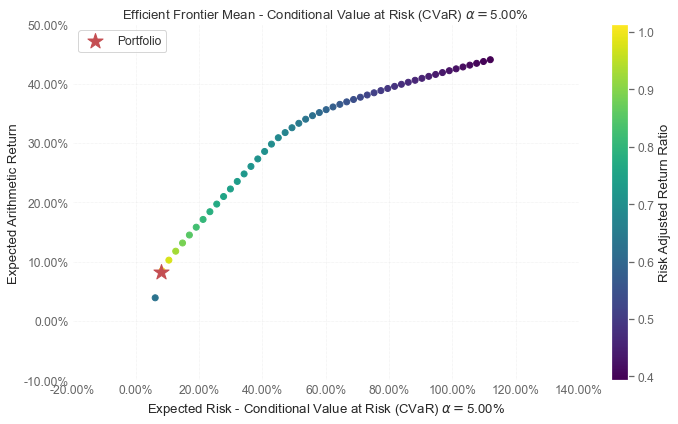

In [31]:
# 2016 optimization 
i=0
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2016, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2016: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2016)
calc_performance(optimal_weights_2016, multiyr_periods_list[i+5])


Optimization # 3 1/1/2017: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      2.207938e-14
EEM      1.474583e-14
QQQ      1.884311e-13
SPY      2.215471e-13
VNQ      1.277195e-13
BND      7.386351e-01
IGOV     3.504431e-13
GLD      1.494808e-14
XLV      2.865506e-13
XLF      1.214489e-11
FXI      7.014741e-15
XRT      1.835309e-13
BTC-USD  1.607665e-02
AAPL     1.027841e-03
TSLA     2.105851e-02
MSFT     6.606332e-03
GOOG     3.092927e-13
AMZN     1.793752e-02
META     5.403566e-04
V        4.400094e-02
JPM      4.405372e-02
XOM      3.792660e-14
WMT      2.664951e-13
JNJ      3.539878e-02
UNH      7.466430e-02
BABA     2.364137e-15

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2017-01-04  2017-01-04
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   61.03%      144.24%
CAGR﹪              10.01%      19.59%

Sharpe              1.4         1.12
Prob. Sharpe Ratio  99.61%      99.07%
Sortino             1.88        1.51
Sortino/√2          1.33        1.07
Omega               1.38        1.38

Max Drawdown        -13.59%     -31.36%
Longest DD Days     186         519

Gain/Pain Ratio     0.38        0.25
Gain/Pain (1M)      2.59        1.53

Payoff Ratio        0.84        0.81
Profit Factor       1.38        1.25
Common Sense Ratio  1.42        1.13
CPC Index           0.7         0.59
Tail Ratio          1.03        0.91
Outlier Win Ratio   7.36        2.63
Outlier Loss Ratio  8.16        2.85

MTD                 0.94%       1.56%
3M                  2.44%       5.

None

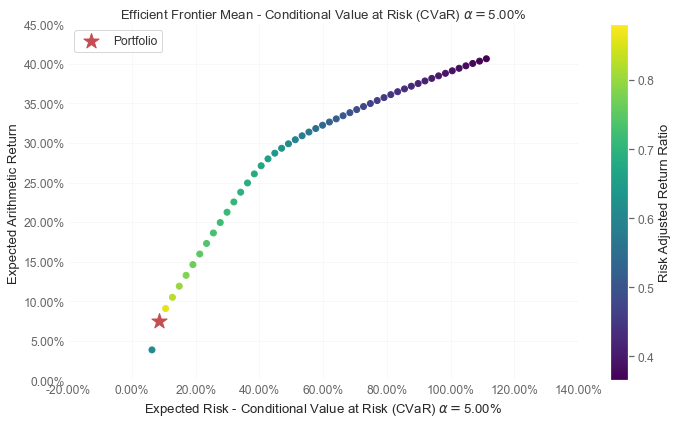

In [32]:
# 2017 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2017, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2017: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2017)
calc_performance(optimal_weights_2017, multiyr_periods_list[i+5])


Optimization # 4 1/1/2018: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.636558e-14
EEM      1.370008e-14
QQQ      4.206049e-13
SPY      5.115046e-13
VNQ      1.897998e-13
BND      6.774245e-01
IGOV     3.134943e-12
GLD      2.275566e-13
XLV      4.493477e-13
XLF      1.606323e-12
FXI      3.501498e-14
XRT      1.552020e-13
BTC-USD  3.618853e-02
AAPL     3.043155e-12
TSLA     2.711044e-02
MSFT     2.548262e-02
GOOG     9.078729e-13
AMZN     3.076516e-04
META     4.204491e-02
V        7.918290e-11
JPM      3.071407e-02
XOM      6.997953e-14
WMT      4.857742e-12
JNJ      4.706364e-02
UNH      1.136636e-01
BABA     1.835802e-13

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-01-03  2018-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   19.37%      29.46%
CAGR﹪              3.61%       5.31%

Sharpe              0.42        0.36
Prob. Sharpe Ratio  81.76%      78.68%
Sortino             0.55        0.48
Sortino/√2          0.39        0.34
Omega               1.09        1.09

Max Drawdown        -21.61%     -31.36%
Longest DD Days     490         519

Gain/Pain Ratio     0.09        0.07
Gain/Pain (1M)      0.39        0.34

Payoff Ratio        0.79        0.82
Profit Factor       1.09        1.07
Common Sense Ratio  1.01        0.92
CPC Index           0.49        0.48
Tail Ratio          0.93        0.86
Outlier Win Ratio   6.06        2.67
Outlier Loss Ratio  6.0         2.78

MTD                 -2.46%      -5.75%
3M                  -0.82%      -0.

None

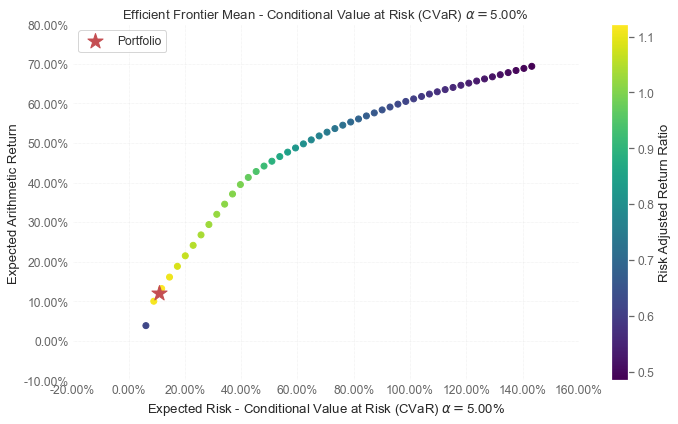

In [33]:
# 2018 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2018, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2018: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2018)
calc_performance(optimal_weights_2018, multiyr_periods_list[i+5])

Optimization # 5 1/1/2019: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.507954e-14
EEM      3.681127e-15
QQQ      5.761247e-14
SPY      5.006644e-14
VNQ      5.043666e-14
BND      8.133243e-01
IGOV     2.691418e-13
GLD      5.447123e-13
XLV      6.438244e-14
XLF      8.022471e-14
FXI      5.168448e-15
XRT      2.051452e-15
BTC-USD  1.622620e-02
AAPL     3.126111e-13
TSLA     1.343415e-13
MSFT     9.864029e-03
GOOG     3.669609e-14
AMZN     2.116850e-02
META     2.098679e-13
V        3.501184e-03
JPM      3.589834e-02
XOM      8.275831e-15
WMT      1.547807e-13
JNJ      1.363818e-13
UNH      1.000175e-01
BABA     4.291417e-15

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2019-01-03  2019-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   12.78%      44.68%
CAGR﹪              3.06%       9.7%

Sharpe              0.42        0.55
Prob. Sharpe Ratio  79.29%      85.97%
Sortino             0.56        0.74
Sortino/√2          0.4         0.52
Omega               1.1         1.1

Max Drawdown        -17.41%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     0.1         0.11
Gain/Pain (1M)      0.42        0.55

Payoff Ratio        0.75        0.81
Profit Factor       1.1         1.11
Common Sense Ratio  1.04        0.98
CPC Index           0.46        0.5
Tail Ratio          0.95        0.89
Outlier Win Ratio   7.7         2.51
Outlier Loss Ratio  7.93        2.7

MTD                 -1.5%       -5.75%
3M                  1.48%       -0.19%


None

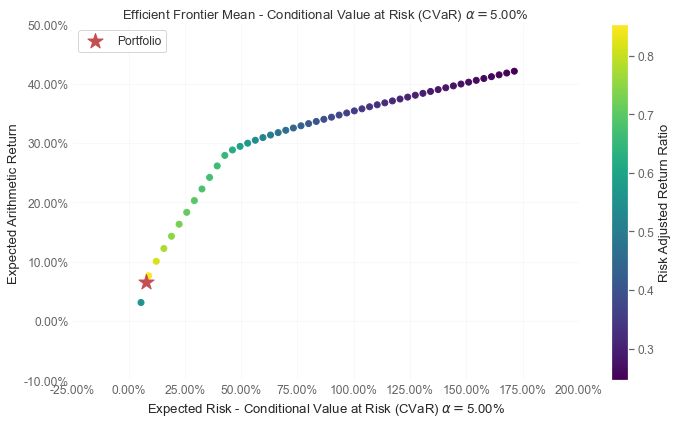

In [34]:
# 2019 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2019, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2019: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2019)
calc_performance(optimal_weights_2019, multiyr_periods_list[i+5])

Optimization # 6 1/1/2020: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.386976e-15
EEM      4.704756e-16
QQQ      3.654766e-15
SPY      4.020700e-15
VNQ      2.522558e-15
BND      8.021186e-01
IGOV     2.562827e-14
GLD      2.386552e-02
XLV      3.487612e-15
XLF      5.399517e-15
FXI      2.549350e-16
XRT      1.212898e-15
BTC-USD  1.376606e-02
AAPL     2.490639e-14
TSLA     4.138519e-15
MSFT     3.822904e-14
GOOG     7.319007e-15
AMZN     4.404474e-02
META     6.382205e-15
V        4.058689e-14
JPM      7.454368e-02
XOM      6.361265e-16
WMT      1.412502e-14
JNJ      6.564871e-15
UNH      4.166143e-02
BABA     1.186695e-15

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-03  2020-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -3.98%      10.68%
CAGR﹪              -1.35%      3.45%

Sharpe              -0.11       0.26
Prob. Sharpe Ratio  42.3%       67.42%
Sortino             -0.15       0.35
Sortino/√2          -0.1        0.25
Omega               0.98        0.98

Max Drawdown        -19.42%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     -0.02       0.05
Gain/Pain (1M)      -0.09       0.24

Payoff Ratio        0.72        0.82
Profit Factor       0.98        1.05
Common Sense Ratio  0.93        0.87
CPC Index           0.39        0.47
Tail Ratio          0.95        0.83
Outlier Win Ratio   9.07        2.81
Outlier Loss Ratio  7.32        2.55

MTD                 -1.6%       -5.75%
3M                  1.61%       -0.

None

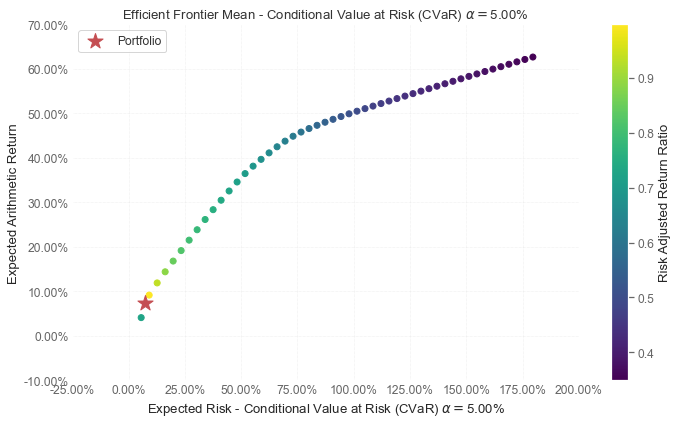

In [35]:
# 2020 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2020, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2020: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2020)
calc_performance(optimal_weights_2020, multiyr_periods_list[i+5])

Optimization # 7 1/1/2021: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      7.747167e-15
EEM      3.109680e-14
QQQ      1.798514e-13
SPY      1.098812e-13
VNQ      1.472303e-14
BND      7.525505e-01
IGOV     4.276099e-12
GLD      4.306692e-02
XLV      1.958672e-13
XLF      1.065291e-13
FXI      6.570636e-14
XRT      1.643499e-14
BTC-USD  3.459033e-02
AAPL     2.441271e-02
TSLA     2.159392e-02
MSFT     5.177266e-13
GOOG     1.387578e-13
AMZN     3.709306e-02
META     8.947434e-14
V        4.043400e-13
JPM      1.494256e-12
XOM      4.666378e-14
WMT      6.733193e-02
JNJ      6.177792e-13
UNH      1.936059e-02
BABA     1.100183e-12

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-05  2021-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -16.54%     -11.08%
CAGR﹪              -8.71%      -5.75%

Sharpe              -1.08       -0.22
Prob. Sharpe Ratio  6.35%       37.65%
Sortino             -1.42       -0.3
Sortino/√2          -1.0        -0.22
Omega               0.83        0.83

Max Drawdown        -21.06%     -29.61%
Longest DD Days     415         416

Gain/Pain Ratio     -0.17       -0.04
Gain/Pain (1M)      -0.52       -0.16

Payoff Ratio        0.74        0.89
Profit Factor       0.83        0.96
Common Sense Ratio  0.65        0.87
CPC Index           0.32        0.44
Tail Ratio          0.78        0.91
Outlier Win Ratio   5.92        2.33
Outlier Loss Ratio  4.97        2.34

MTD                 -2.93%      -5.75%
3M                  -1.74%   

None

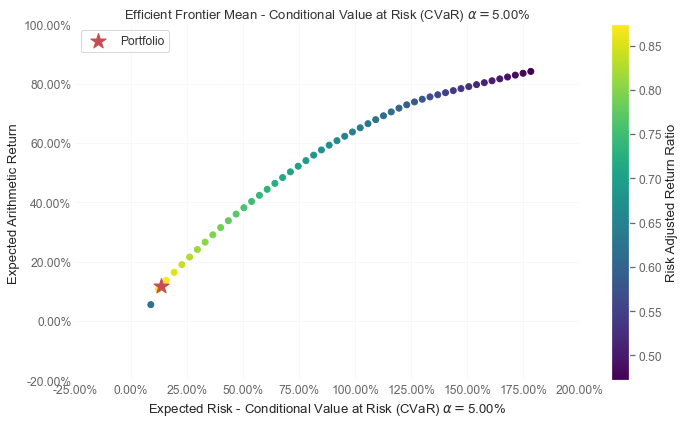

In [36]:
# 2021 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2021, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2021: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2021)
calc_performance(optimal_weights_2021, multiyr_periods_list[i+5])

Optimization # 8 1/1/2022: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      4.406340e-14
EEM      4.073859e-15
QQQ      4.462782e-13
SPY      3.352171e-13
VNQ      1.710561e-13
BND      6.812173e-01
IGOV     4.345499e-12
GLD      7.555125e-02
XLV      1.154620e-12
XLF      2.113263e-13
FXI      2.916248e-15
XRT      4.656134e-13
BTC-USD  3.407330e-02
AAPL     3.443982e-02
TSLA     3.477168e-02
MSFT     6.119531e-02
GOOG     1.328023e-12
AMZN     6.860345e-03
META     2.046966e-13
V        7.058732e-13
JPM      6.225046e-13
XOM      6.864557e-14
WMT      4.332213e-02
JNJ      9.140437e-13
UNH      2.856884e-02
BABA     1.817798e-14

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-01-04  2022-01-04
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -18.69%     -25.53%
CAGR﹪              -18.93%     -25.83%

Sharpe              -1.85       -1.17
Prob. Sharpe Ratio  3.44%       12.33%
Sortino             -2.43       -1.57
Sortino/√2          -1.72       -1.11
Omega               0.74        0.74

Max Drawdown        -19.65%     -27.61%
Longest DD Days     359         351

Gain/Pain Ratio     -0.26       -0.17
Gain/Pain (1M)      -0.72       -0.62

Payoff Ratio        0.93        1.05
Profit Factor       0.74        0.83
Common Sense Ratio  0.62        0.75
CPC Index           0.31        0.39
Tail Ratio          0.84        0.91
Outlier Win Ratio   4.51        2.04
Outlier Loss Ratio  4.81        2.42

MTD                 -3.32%      -5.75%
3M                  -1.79% 

None

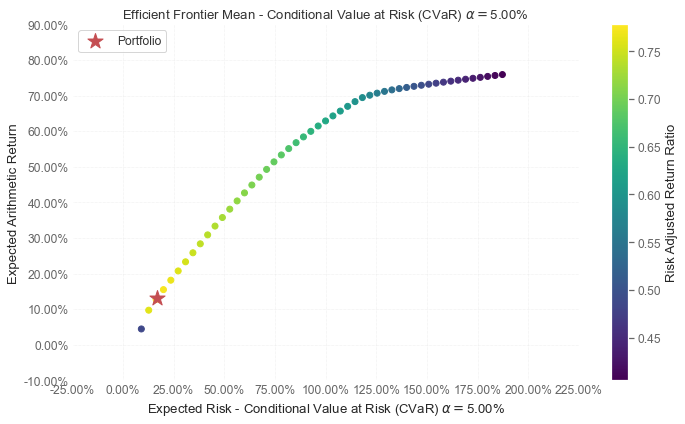

In [37]:
# 2022 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2022, _ = calculate_w(daily_returns_last_5yr, rm='CVaR')
print(f'Optimization # {i+2} 1/1/2022: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2022)
calc_performance(optimal_weights_2022, multiyr_periods_list[i+5])

## Riskfolio Multi-Period Optimization based on MV: Initial 2015

weights
GSG      8.471924e-09
EEM      6.306753e-09
QQQ      3.536581e-08
SPY      3.465154e-08
VNQ      1.968200e-08
BND      7.868873e-01
IGOV     2.740066e-08
GLD      1.703957e-08
XLV      1.690734e-02
XLF      1.785987e-08
FXI      7.775674e-09
XRT      1.644173e-02
BTC-USD  2.218817e-08
AAPL     2.877871e-02
TSLA     1.332303e-02
MSFT     2.741856e-08
GOOG     1.631632e-08
AMZN     1.896475e-08
META     7.579259e-03
V        2.306938e-02
JPM      1.516433e-08
XOM      2.843050e-08
WMT      1.884229e-02
JNJ      3.457838e-02
UNH      3.558456e-02
BABA     1.800774e-02

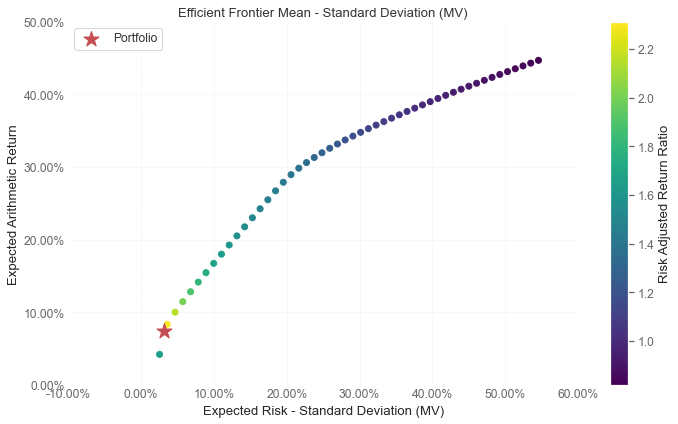

In [48]:
optimal_weights_mv, ax = calculate_w(hist_returns, rm='MV')
optimal_weights_mv

In [51]:
calc_performance(optimal_weights=optimal_weights_mv)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2019-12-31  2019-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   31.68%      90.86%
CAGR﹪              5.67%       13.83%

Sharpe              1.54        1.09
Prob. Sharpe Ratio  99.97%      99.17%
Sortino             2.27        1.54
Sortino/√2          1.61        1.09
Omega               1.29        1.29

Max Drawdown        -3.81%      -19.25%
Longest DD Days     324         519

Gain/Pain Ratio     0.29        0.21
Gain/Pain (1M)      2.05        1.38

Payoff Ratio        0.96        0.9
Profit Factor       1.29        1.21
Common Sense Ratio  1.34        1.14
CPC Index           0.7         0.6
Tail Ratio          1.04        0.95
Outlier Win Ratio   6.95        2.13
Outlier Loss Ratio  8.25        2.41

MTD                 1.2%        4.16%
3M                  4.61%       11.98

None

### Riskfolio Multi-Period Optimization based on MV: 2016-2022

Optimization # 2 1/1/2016: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      2.223092e-09
EEM      2.015563e-09
QQQ      1.196189e-08
SPY      9.580480e-09
VNQ      5.561066e-09
BND      8.001306e-01
IGOV     1.147668e-08
GLD      4.474320e-09
XLV      2.164049e-02
XLF      5.947827e-09
FXI      2.609928e-09
XRT      1.060511e-08
BTC-USD  3.956857e-08
AAPL     1.007524e-02
TSLA     1.733185e-02
MSFT     2.060743e-04
GOOG     3.291954e-08
AMZN     1.104994e-04
META     1.087187e-02
V        7.884601e-02
JPM      7.774443e-09
XOM      5.573382e-09
WMT      1.114363e-08
JNJ      1.588398e-02
UNH      4.490320e-02
BABA     6.807133e-09

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-01-05  2016-01-05
End Period          2020-12-31  2020-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   50.26%      138.75%
CAGR﹪              8.5%        19.05%

Sharpe              1.37        1.1
Prob. Sharpe Ratio  99.55%      98.95%
Sortino             1.87        1.48
Sortino/√2          1.32        1.05
Omega               1.36        1.36

Max Drawdown        -11.34%     -31.36%
Longest DD Days     161         519

Gain/Pain Ratio     0.36        0.25
Gain/Pain (1M)      2.76        1.62

Payoff Ratio        0.86        0.8
Profit Factor       1.36        1.25
Common Sense Ratio  1.35        1.19
CPC Index           0.69        0.57
Tail Ratio          0.99        0.95
Outlier Win Ratio   7.83        2.51
Outlier Loss Ratio  8.95        2.79

MTD                 1.32%       5.53%
3M                  3.36%       16.9

None

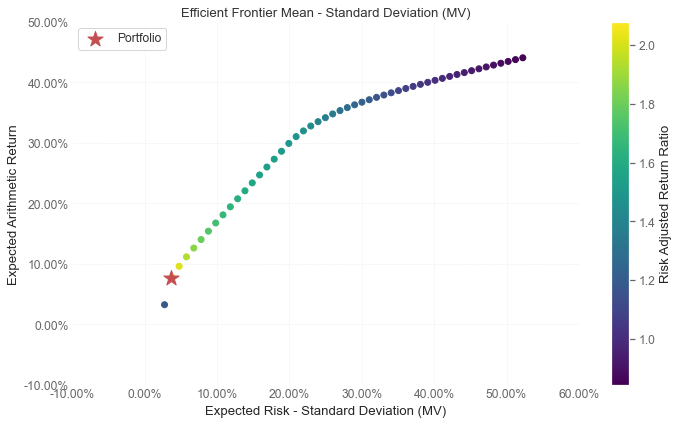

In [52]:
# 2016 optimization 
i=0
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2016, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2016: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2016)
calc_performance(optimal_weights_2016, multiyr_periods_list[i+5])


Optimization # 3 1/1/2017: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.145675e-08
EEM      1.210718e-08
QQQ      6.782131e-08
SPY      6.694606e-08
VNQ      4.178102e-08
BND      7.194940e-01
IGOV     7.303730e-08
GLD      2.349980e-08
XLV      8.012089e-08
XLF      2.773204e-07
FXI      1.410202e-08
XRT      4.549205e-08
BTC-USD  1.877817e-02
AAPL     4.467784e-03
TSLA     1.880758e-02
MSFT     6.211225e-03
GOOG     6.767837e-08
AMZN     2.115323e-02
META     4.874452e-03
V        4.170673e-02
JPM      4.193890e-02
XOM      2.441804e-08
WMT      4.467874e-08
JNJ      5.437884e-02
UNH      6.818824e-02
BABA     1.899414e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2017-01-04  2017-01-04
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   63.03%      144.24%
CAGR﹪              10.29%      19.59%

Sharpe              1.4         1.12
Prob. Sharpe Ratio  99.64%      99.07%
Sortino             1.9         1.51
Sortino/√2          1.34        1.07
Omega               1.38        1.38

Max Drawdown        -13.53%     -31.36%
Longest DD Days     199         519

Gain/Pain Ratio     0.38        0.25
Gain/Pain (1M)      2.51        1.53

Payoff Ratio        0.83        0.82
Profit Factor       1.38        1.25
Common Sense Ratio  1.43        1.13
CPC Index           0.69        0.6
Tail Ratio          1.04        0.91
Outlier Win Ratio   7.28        2.65
Outlier Loss Ratio  7.84        2.86

MTD                 1.0%        1.56%
3M                  2.43%       5.0

None

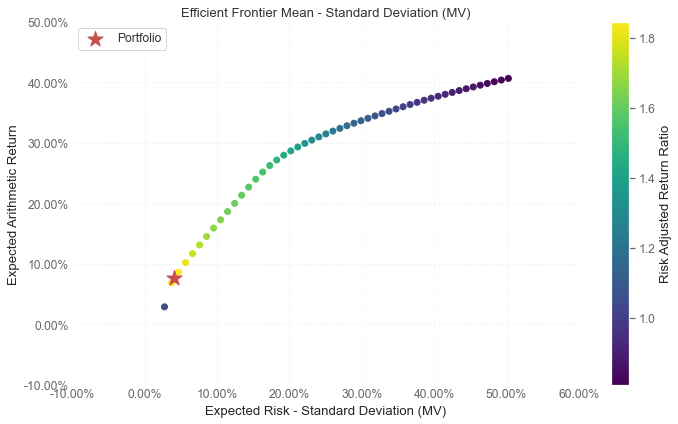

In [53]:
# 2017 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2017, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2017: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2017)
calc_performance(optimal_weights_2017, multiyr_periods_list[i+5])


Optimization # 4 1/1/2018: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      8.568124e-09
EEM      8.856049e-09
QQQ      3.695556e-08
SPY      3.895496e-08
VNQ      1.753676e-08
BND      6.670103e-01
IGOV     9.225456e-08
GLD      2.026424e-08
XLV      3.233696e-08
XLF      8.049157e-08
FXI      1.024362e-08
XRT      1.862288e-08
BTC-USD  4.260297e-02
AAPL     2.019186e-03
TSLA     1.914315e-02
MSFT     2.808646e-02
GOOG     4.861507e-08
AMZN     9.928088e-03
META     3.535817e-02
V        1.605815e-02
JPM      3.740396e-02
XOM      1.387035e-08
WMT      5.721823e-08
JNJ      4.487415e-02
UNH      9.751490e-02
BABA     3.105315e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-01-03  2018-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   18.59%      29.46%
CAGR﹪              3.47%       5.31%

Sharpe              0.4         0.36
Prob. Sharpe Ratio  80.66%      78.68%
Sortino             0.53        0.48
Sortino/√2          0.37        0.34
Omega               1.08        1.08

Max Drawdown        -22.23%     -31.36%
Longest DD Days     480         519

Gain/Pain Ratio     0.08        0.07
Gain/Pain (1M)      0.37        0.34

Payoff Ratio        0.8         0.84
Profit Factor       1.08        1.07
Common Sense Ratio  1.02        0.92
CPC Index           0.49        0.49
Tail Ratio          0.94        0.86
Outlier Win Ratio   5.96        2.68
Outlier Loss Ratio  5.94        2.8

MTD                 -2.34%      -5.75%
3M                  -0.25%      -0.1

None

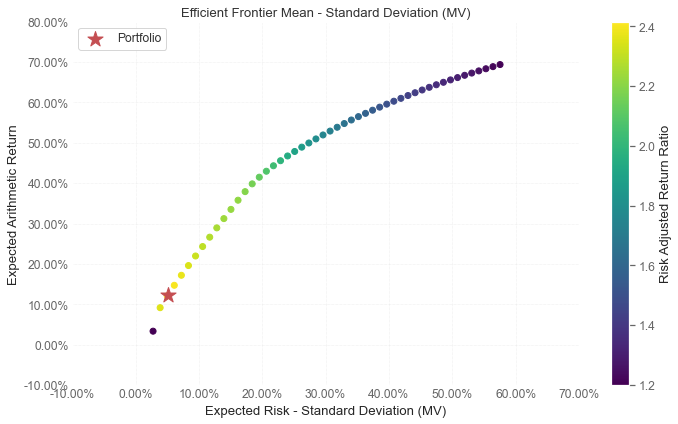

In [54]:
# 2018 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2018, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2018: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2018)
calc_performance(optimal_weights_2018, multiyr_periods_list[i+5])

Optimization # 5 1/1/2019: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      1.781693e-08
EEM      2.379913e-08
QQQ      6.319345e-08
SPY      5.904958e-08
VNQ      5.276641e-08
BND      7.986141e-01
IGOV     1.263905e-07
GLD      1.647099e-07
XLV      6.558067e-08
XLF      8.337189e-08
FXI      2.912341e-08
XRT      2.952840e-08
BTC-USD  1.729261e-02
AAPL     4.995044e-07
TSLA     1.291483e-07
MSFT     2.662651e-02
GOOG     4.446413e-08
AMZN     1.957363e-02
META     2.576719e-07
V        7.865694e-03
JPM      3.596728e-02
XOM      2.314572e-08
WMT      8.629795e-08
JNJ      2.123401e-07
UNH      9.405815e-02
BABA     3.237871e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2019-01-03  2019-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   14.26%      44.68%
CAGR﹪              3.4%        9.7%

Sharpe              0.45        0.55
Prob. Sharpe Ratio  80.96%      85.97%
Sortino             0.6         0.74
Sortino/√2          0.43        0.52
Omega               1.1         1.1

Max Drawdown        -17.83%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     0.1         0.11
Gain/Pain (1M)      0.45        0.55

Payoff Ratio        0.78        0.81
Profit Factor       1.1         1.11
Common Sense Ratio  1.04        0.98
CPC Index           0.48        0.5
Tail Ratio          0.94        0.89
Outlier Win Ratio   7.41        2.52
Outlier Loss Ratio  7.85        2.73

MTD                 -1.57%      -5.75%
3M                  1.54%       -0.19%

None

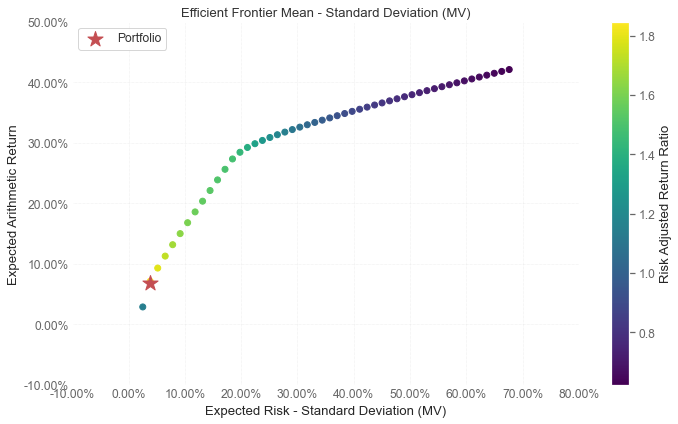

In [55]:
# 2019 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2019, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2019: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2019)
calc_performance(optimal_weights_2019, multiyr_periods_list[i+5])

Optimization # 6 1/1/2020: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      5.524074e-08
EEM      4.035838e-08
QQQ      9.113324e-08
SPY      9.818258e-08
VNQ      7.185240e-08
BND      7.963724e-01
IGOV     2.636720e-07
GLD      1.233907e-02
XLV      8.170986e-08
XLF      1.095284e-07
FXI      3.785689e-08
XRT      4.694117e-08
BTC-USD  1.845194e-02
AAPL     7.737636e-04
TSLA     7.806312e-08
MSFT     9.731447e-03
GOOG     9.903176e-08
AMZN     4.104342e-02
META     1.308128e-07
V        1.883982e-03
JPM      8.142616e-02
XOM      4.089443e-08
WMT      4.477808e-07
JNJ      1.951482e-07
UNH      3.797587e-02
BABA     5.885703e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-03  2020-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -3.52%      10.68%
CAGR﹪              -1.19%      3.45%

Sharpe              -0.09       0.26
Prob. Sharpe Ratio  44.07%      67.42%
Sortino             -0.11       0.35
Sortino/√2          -0.08       0.25
Omega               0.98        0.98

Max Drawdown        -20.11%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     -0.02       0.05
Gain/Pain (1M)      -0.07       0.24

Payoff Ratio        0.73        0.83
Profit Factor       0.98        1.05
Common Sense Ratio  0.94        0.87
CPC Index           0.4         0.47
Tail Ratio          0.96        0.83
Outlier Win Ratio   8.63        2.8
Outlier Loss Ratio  7.15        2.59

MTD                 -1.69%      -5.75%
3M                  1.69%       -0.1

None

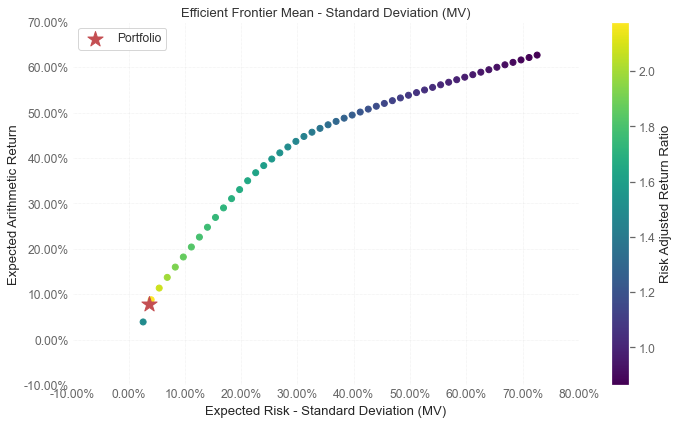

In [56]:
# 2020 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2020, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2020: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2020)
calc_performance(optimal_weights_2020, multiyr_periods_list[i+5])

Optimization # 7 1/1/2021: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      3.630815e-09
EEM      4.412662e-09
QQQ      7.991439e-09
SPY      6.483959e-09
VNQ      3.254689e-09
BND      4.237068e-01
IGOV     1.615842e-01
GLD      1.107236e-01
XLV      7.373772e-09
XLF      6.142582e-09
FXI      4.657450e-09
XRT      3.911503e-09
BTC-USD  4.919457e-02
AAPL     5.292098e-02
TSLA     3.647581e-02
MSFT     4.584694e-08
GOOG     5.197912e-09
AMZN     6.610116e-02
META     4.414015e-09
V        1.560553e-08
JPM      1.994950e-08
XOM      2.105713e-09
WMT      8.170054e-02
JNJ      2.714746e-08
UNH      1.759203e-02
BABA     7.258707e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-05  2021-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -20.87%     -11.08%
CAGR﹪              -11.13%     -5.75%

Sharpe              -1.01       -0.22
Prob. Sharpe Ratio  7.58%       37.65%
Sortino             -1.34       -0.3
Sortino/√2          -0.95       -0.22
Omega               0.84        0.84

Max Drawdown        -25.58%     -29.61%
Longest DD Days     416         416

Gain/Pain Ratio     -0.16       -0.04
Gain/Pain (1M)      -0.51       -0.16

Payoff Ratio        0.81        0.92
Profit Factor       0.84        0.96
Common Sense Ratio  0.79        0.87
CPC Index           0.34        0.45
Tail Ratio          0.94        0.91
Outlier Win Ratio   4.66        2.62
Outlier Loss Ratio  4.34        2.66

MTD                 -4.31%      -5.75%
3M                  -3.03%   

None

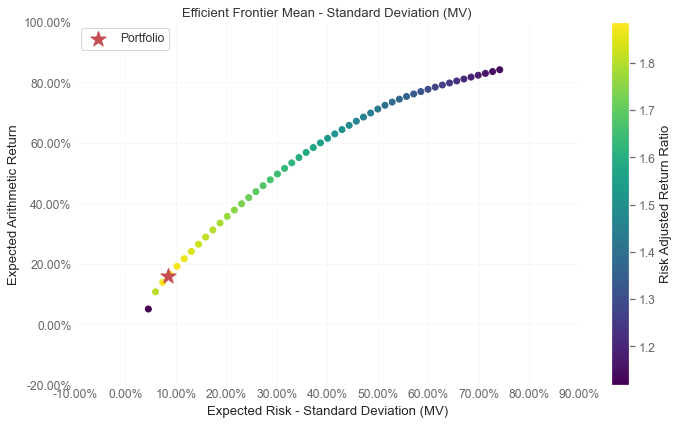

In [57]:
# 2021 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2021, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2021: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2021)
calc_performance(optimal_weights_2021, multiyr_periods_list[i+5])

Optimization # 8 1/1/2022: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation 



weights
GSG      4.259632e-08
EEM      2.864303e-08
QQQ      7.401553e-08
SPY      5.885248e-08
VNQ      3.931660e-08
BND      4.739595e-01
IGOV     1.781382e-02
GLD      1.474070e-01
XLV      1.340379e-07
XLF      4.430270e-08
FXI      2.545229e-08
XRT      5.659212e-08
BTC-USD  4.848142e-02
AAPL     7.983074e-02
TSLA     5.385418e-02
MSFT     8.277429e-02
GOOG     1.361424e-07
AMZN     1.310579e-02
META     4.228243e-08
V        7.202614e-08
JPM      6.840244e-08
XOM      2.070022e-08
WMT      5.831657e-02
JNJ      1.297955e-07
UNH      2.445566e-02
BABA     2.498533e-08

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-01-04  2022-01-04
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -22.21%     -25.53%
CAGR﹪              -22.48%     -25.83%

Sharpe              -1.71       -1.17
Prob. Sharpe Ratio  4.52%       12.33%
Sortino             -2.24       -1.57
Sortino/√2          -1.58       -1.11
Omega               0.76        0.76

Max Drawdown        -22.6%      -27.61%
Longest DD Days     359         351

Gain/Pain Ratio     -0.24       -0.17
Gain/Pain (1M)      -0.7        -0.62

Payoff Ratio        0.93        1.03
Profit Factor       0.76        0.83
Common Sense Ratio  0.65        0.75
CPC Index           0.32        0.39
Tail Ratio          0.86        0.91
Outlier Win Ratio   3.81        2.21
Outlier Loss Ratio  4.2         2.71

MTD                 -4.76%      -5.75%
3M                  -3.58% 

None

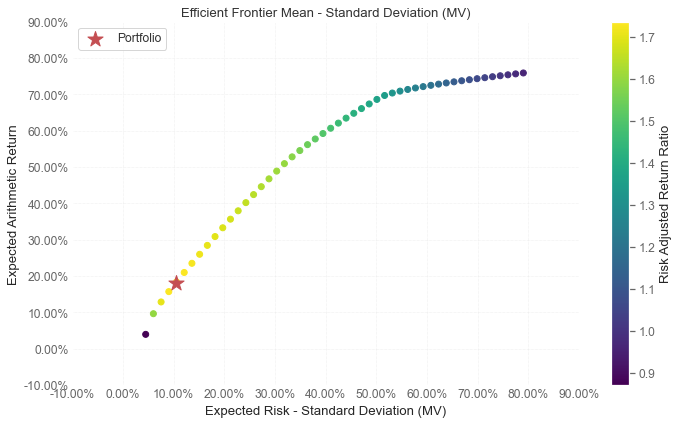

In [58]:
# 2022 optimization 
i+=1
daily_returns_last_5yr = price_returns_dict[multiyr_periods_list[i]]['returns']
optimal_weights_2022, _ = calculate_w(daily_returns_last_5yr, rm='MV')
print(f'Optimization # {i+2} 1/1/2022: Optimized Portfolio Weights, Efficient Frontier and Performance Evaluation \n')
display(optimal_weights_2022)
calc_performance(optimal_weights_2022, multiyr_periods_list[i+5])

# PyPortfolioOpt Weights Optimizations:

In [ ]:
def optimize_pypfopt(stock_data=hist_prices, objective="max_sharpe", next_5yr= '2015 ⟺ 2020'): #, pf_capital_start=100000):
    """
    Available options for pypfopt optimization objectives:
    - ``min_volatility()`` optimizes for minimum volatility
    - ``max_sharpe()`` optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)
    - ``max_quadratic_utility()`` maximises the quadratic utility, given some risk aversion.
    - ``efficient_risk()`` maximises return for a given target risk
    - ``efficient_return()`` minimises risk for a given target return
    """
    
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(stock_data)
    S = risk_models.sample_cov(stock_data)

    # Instantiate optimizer class & define portfolio constraints:
    # weight bounds apply 2 constraints - allowing short positions and maximium short & long position sizes
    ef = EfficientFrontier(mu, S, weight_bounds=(-0.3, 0.5)) 
    
    
    ef.add_constraint(lambda x: cp.sum(x) <= 1.5) # setting net exposure limits upper end (150% net long)
    ef.add_constraint(lambda x: cp.sum(x) >= -0.5) # setting net exposure limits lower end (50% net short)
    ef.add_constraint(lambda x: cp.sum(cp.abs(x)) <= 2) # setting gross exposure / leverage limits 
    ef.add_objective(ppo.L2_reg, gamma=1) # adds a penalty for negligible weights to minimize zero weights
    
    # Optimize for given objective 
    if objective == "max_sharpe":
        weights = ef.max_sharpe()    
    elif objective == "max_quadratic_utility":
        weights = ef.max_quadratic_utility()
    elif objective == "efficient_risk":
        weights = ef.efficient_risk()
        ef.add_constraint()
        
    # rounded_weights = ef.clean_weights()

    cols = ['symbol', 'optimized']
    weights_df = pd.DataFrame(weights.items(), columns=cols)
    weights_df.set_index('symbol', inplace=True)
    display(weights_df)
    
    ef.portfolio_performance(verbose=True)
    
    # daily asset returns in forward 5 years: 
    daily_returns_next_5yr = price_returns_dict[next_5yr]['returns']
    daily_returns_ntm = price_returns_dict[]
    
    optimal_returns_fwd, uniform_returns_fwd = returns_fwd(daily_returns_next_5yr, optimal_weights=weights_df)
    report = qs.reports.metrics(optimal_returns_fwd, benchmark = uniform_returns_fwd)
    display(report)

    #return report #optimized, uniform, report

## PyPortfolioOpt max_sharpe Optimization Runs: 

In [ ]:
# initial optimization on 1/1/2015: 

optimize_pypfopt()

optimized
symbol            
GSG      -0.080481
EEM      -0.043030
QQQ       0.060784
SPY       0.042929
VNQ       0.057989
BND       0.015026
IGOV     -0.008125
GLD      -0.011341
XLV       0.067888
XLF       0.025322
FXI      -0.028399
XRT       0.085604
BTC-USD  -0.300003
AAPL      0.135281
TSLA      0.240206
MSFT      0.025851
GOOG      0.015024
AMZN      0.050787
META      0.119675
V         0.104485
JPM       0.009362
XOM       0.010628
WMT       0.050364
JNJ       0.046824
UNH       0.118590
BABA      0.188760

Expected annual return: 68.6%
Annual volatility: 32.6%
Sharpe Ratio: 2.04
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2019-12-31  2019-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -6.39%      90.86%
CAGR﹪              -1.32%      13.83%

Sharpe              0.12        1.09
Prob. Sharpe Ratio  60.66%      99.17%
Sortino             0.17        1.54
Sortino/√2          0.12        1.09
Omega               1.02        1.02

Max Drawdown        -56.53%     -19.25%
Longest DD Days     1595        519

Gain/Pain Ratio     0.02        0.21
Gain/Pain (1M)      0.11        1.38

Payoff Ratio        0.84        0.96
Profit Factor       1.02        1.21
Common Sense Ratio  0.91        1.14
CPC Index           0.45        0.64
Tail Ratio          0.9         0.95
Outlier Win Ratio   2.48        6.3
Outlier Loss Ratio  2.45        6.55



None

### PyPortfolioOpt max_sharpe Multi-Period Optimizations: 2016-2022

In [ ]:
for i, year in enumerate(range(2016, 2023)):
    stock_data = price_returns_dict[multiyr_periods_list[i]]['prices']
    # performance_optimal, performance_equal = optimize_pypfopt(tickers, f"{year}-01-01", f"{year+1}-01-01")
    optimize_pypfopt(stock_data=stock_data, next_5yr=multiyr_periods_list[i+5])

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.733857
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.000000
AAPL      0.003376
TSLA      0.034241
MSFT      0.000000
GOOG      0.000000
AMZN      0.000855
META      0.018457
V         0.132634
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.076580
BABA      0.000000

Expected annual return: 11.6%
Annual volatility: 5.2%
Sharpe Ratio: 1.87
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-01-05  2016-01-05
End Period          2020-12-31  2020-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   65.8%       138.75%
CAGR﹪              10.66%      19.05%

Sharpe              1.36        1.1
Prob. Sharpe Ratio  99.69%      98.95%
Sortino             1.89        1.48
Sortino/√2          1.33        1.05
Omega               1.34        1.34

Max Drawdown        -14.68%     -31.36%
Longest DD Days     156         519

Gain/Pain Ratio     0.34        0.25
Gain/Pain (1M)      2.72        1.62

Payoff Ratio        0.89        0.83
Profit Factor       1.34        1.25
Common Sense Ratio  1.38        1.19
CPC Index           0.69        0.6
Tail Ratio          1.02        0.95
Outlier Win Ratio   6.55        2.77
Outlier Loss Ratio  7.45        3.01

M

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.488562
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.042203
AAPL      0.000000
TSLA      0.045810
MSFT      0.009993
GOOG      0.000000
AMZN      0.054400
META      0.010739
V         0.083535
JPM       0.041181
XOM       0.000000
WMT       0.000000
JNJ       0.074162
UNH       0.149416
BABA      0.000000

Expected annual return: 15.6%
Annual volatility: 7.7%
Sharpe Ratio: 1.76
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2017-01-04  2017-01-04
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   123.84%     144.24%
CAGR﹪              17.52%      19.59%

Sharpe              1.44        1.12
Prob. Sharpe Ratio  99.83%      99.07%
Sortino             1.98        1.51
Sortino/√2          1.4         1.07
Omega               1.34        1.34

Max Drawdown        -20.86%     -31.36%
Longest DD Days     249         519

Gain/Pain Ratio     0.34        0.25
Gain/Pain (1M)      2.29        1.53

Payoff Ratio        0.89        0.84
Profit Factor       1.34        1.25
Common Sense Ratio  1.42        1.13
CPC Index           0.7         0.61
Tail Ratio          1.06        0.91
Outlier Win Ratio   4.84        3.25
Outlier Loss Ratio  5.49        3.48


None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.374888
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.136436
AAPL      0.000000
TSLA      0.041028
MSFT      0.062482
GOOG      0.000000
AMZN      0.024562
META      0.084208
V         0.022572
JPM       0.007847
XOM       0.000000
WMT       0.000000
JNJ       0.036524
UNH       0.209452
BABA      0.000000

Expected annual return: 43.6%
Annual volatility: 12.6%
Sharpe Ratio: 3.30
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-01-03  2018-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   31.04%      29.46%
CAGR﹪              5.57%       5.31%

Sharpe              0.39        0.36
Prob. Sharpe Ratio  80.04%      78.68%
Sortino             0.51        0.48
Sortino/√2          0.36        0.34
Omega               1.07        1.07

Max Drawdown        -34.65%     -31.36%
Longest DD Days     532         519

Gain/Pain Ratio     0.07        0.07
Gain/Pain (1M)      0.33        0.34

Payoff Ratio        0.85        0.85
Profit Factor       1.07        1.07
Common Sense Ratio  1.0         0.92
CPC Index           0.5         0.5
Tail Ratio          0.93        0.86
Outlier Win Ratio   3.67        3.49
Outlier Loss Ratio  3.94        3.65

M

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.603945
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.046513
AAPL      0.000000
TSLA      0.000000
MSFT      0.070068
GOOG      0.000000
AMZN      0.052711
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.226764
BABA      0.000000

Expected annual return: 14.5%
Annual volatility: 7.4%
Sharpe Ratio: 1.70
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2019-01-03  2019-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   34.05%      44.68%
CAGR﹪              7.62%       9.7%

Sharpe              0.66        0.55
Prob. Sharpe Ratio  89.79%      85.97%
Sortino             0.89        0.74
Sortino/√2          0.63        0.52
Omega               1.14        1.14

Max Drawdown        -19.02%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     0.14        0.11
Gain/Pain (1M)      0.74        0.55

Payoff Ratio        0.85        0.84
Profit Factor       1.14        1.11
Common Sense Ratio  1.12        0.98
CPC Index           0.54        0.52
Tail Ratio          0.99        0.89
Outlier Win Ratio   5.33        3.05
Outlier Loss Ratio  5.42        3.05

MT

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.644653
IGOV      0.000000
GLD       0.042893
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.043958
AAPL      0.000000
TSLA      0.000000
MSFT      0.025947
GOOG      0.000000
AMZN      0.092673
META      0.000000
V         0.000000
JPM       0.079236
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.070641
BABA      0.000000

Expected annual return: 14.3%
Annual volatility: 5.9%
Sharpe Ratio: 2.08
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-03  2020-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   1.69%       10.68%
CAGR﹪              0.56%       3.45%

Sharpe              0.11        0.26
Prob. Sharpe Ratio  57.28%      67.42%
Sortino             0.14        0.35
Sortino/√2          0.1         0.25
Omega               1.02        1.02

Max Drawdown        -23.88%     -31.36%
Longest DD Days     415         416

Gain/Pain Ratio     0.02        0.05
Gain/Pain (1M)      0.09        0.24

Payoff Ratio        0.79        0.85
Profit Factor       1.02        1.05
Common Sense Ratio  0.92        0.87
CPC Index           0.45        0.48
Tail Ratio          0.9         0.83
Outlier Win Ratio   6.31        2.91
Outlier Loss Ratio  5.82        2.89

M

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.108201
IGOV      0.122217
GLD       0.194468
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.151950
AAPL      0.093634
TSLA      0.094327
MSFT      0.000000
GOOG      0.000000
AMZN      0.108310
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.116659
JNJ       0.000000
UNH       0.010234
BABA      0.000000

Expected annual return: 41.1%
Annual volatility: 16.9%
Sharpe Ratio: 2.31
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-05  2021-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -29.03%     -11.08%
CAGR﹪              -15.88%     -5.75%

Sharpe              -0.74       -0.22
Prob. Sharpe Ratio  14.71%      37.65%
Sortino             -0.97       -0.3
Sortino/√2          -0.68       -0.22
Omega               0.88        0.88

Max Drawdown        -40.13%     -29.61%
Longest DD Days     416         416

Gain/Pain Ratio     -0.12       -0.04
Gain/Pain (1M)      -0.41       -0.16

Payoff Ratio        0.83        0.89
Profit Factor       0.88        0.96
Common Sense Ratio  0.74        0.87
CPC Index           0.37        0.44
Tail Ratio          0.84        0.91
Outlier Win Ratio   3.05        3.27
Outlier Loss Ratio  3.25        

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.233852
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.163717
AAPL      0.174727
TSLA      0.166377
MSFT      0.190350
GOOG      0.000000
AMZN      0.000000
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.054718
JNJ       0.000000
UNH       0.016259
BABA      0.000000

Expected annual return: 53.1%
Annual volatility: 23.8%
Sharpe Ratio: 2.14
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-01-04  2022-01-04
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -40.93%     -25.53%
CAGR﹪              -41.36%     -25.83%

Sharpe              -1.62       -1.17
Prob. Sharpe Ratio  5.09%       12.33%
Sortino             -2.06       -1.57
Sortino/√2          -1.46       -1.11
Omega               0.77        0.77

Max Drawdown        -41.86%     -27.61%
Longest DD Days     269         351

Gain/Pain Ratio     -0.23       -0.17
Gain/Pain (1M)      -0.71       -0.62

Payoff Ratio        0.87        0.97
Profit Factor       0.77        0.83
Common Sense Ratio  0.6         0.75
CPC Index           0.32        0.36
Tail Ratio          0.78        0.91
Outlier Win Ratio   2.6         3.03
Outlier Loss Ratio  2.76      

None

## PyPortfolioOpt max_quadratic_utility Optimization Runs: 

In [ ]:
# initial optimization 1/1/2015: 

optimize_pypfopt(objective="max_quadratic_utility")

optimized
symbol            
GSG        0.00000
EEM        0.00000
QQQ        0.00000
SPY        0.00000
VNQ        0.00000
BND        0.00000
IGOV       0.00000
GLD        0.00000
XLV        0.00000
XLF        0.00000
FXI        0.00000
XRT        0.00000
BTC-USD    0.00000
AAPL       0.00000
TSLA       0.77602
MSFT       0.00000
GOOG       0.00000
AMZN       0.00000
META       0.00000
V          0.00000
JPM        0.00000
XOM        0.00000
WMT        0.00000
JNJ        0.00000
UNH        0.00000
BABA       0.22398

Expected annual return: 59.5%
Annual volatility: 47.4%
Sharpe Ratio: 1.21
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-01-05  2015-01-05
End Period          2019-12-31  2019-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   36.52%      90.86%
CAGR﹪              6.44%       13.83%

Sharpe              0.35        1.09
Prob. Sharpe Ratio  78.52%      99.17%
Sortino             0.5         1.54
Sortino/√2          0.35        1.09
Omega               1.06        1.06

Max Drawdown        -54.91%     -19.25%
Longest DD Days     833         519

Gain/Pain Ratio     0.06        0.21
Gain/Pain (1M)      0.32        1.38

Payoff Ratio        0.98        0.94
Profit Factor       1.06        1.21
Common Sense Ratio  0.98        1.14
CPC Index           0.53        0.63
Tail Ratio          0.92        0.95
Outlier Win Ratio   2.32        7.03
Outlier Loss Ratio  2.67        7.59


None

### max_quadratic_utility multi-year optimizations 2016-2022

In [ ]:
for i, year in enumerate(range(2016, 2023)):
    stock_data = price_returns_dict[multiyr_periods_list[i]]['prices']
    # performance_optimal, performance_equal = optimize_pypfopt(tickers, f"{year}-01-01", f"{year+1}-01-01")
    optimize_pypfopt(stock_data=stock_data, objective="max_quadratic_utility", next_5yr=multiyr_periods_list[i+5])
    
    # print(f"Performance for year {year}:")
    # print(f"Optimal: {performance_optimal}")
    # print(f"Equal: {performance_equal}")


optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.000000
AAPL      0.000000
TSLA      0.820542
MSFT      0.000000
GOOG      0.000000
AMZN      0.000000
META      0.000000
V         0.179458
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.000000
BABA      0.000000

Expected annual return: 51.9%
Annual volatility: 44.6%
Sharpe Ratio: 1.12
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-01-05  2016-01-05
End Period          2020-12-31  2020-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   533.94%     138.75%
CAGR﹪              44.77%      19.05%

Sharpe              1.0         1.1
Prob. Sharpe Ratio  98.63%      98.95%
Sortino             1.45        1.48
Sortino/√2          1.03        1.05
Omega               1.21        1.21

Max Drawdown        -59.42%     -31.36%
Longest DD Days     836         519

Gain/Pain Ratio     0.21        0.25
Gain/Pain (1M)      1.15        1.62

Payoff Ratio        0.97        0.83
Profit Factor       1.21        1.25
Common Sense Ratio  1.45        1.19
CPC Index           0.63        0.59
Tail Ratio          1.2         0.95
Outlier Win Ratio   2.81        9.16
Outlier Loss Ratio  3.02        8.5



None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.207877
AAPL      0.000000
TSLA      0.779582
MSFT      0.000000
GOOG      0.000000
AMZN      0.012541
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.000000
BABA      0.000000

Expected annual return: 47.5%
Annual volatility: 42.0%
Sharpe Ratio: 1.08
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2017-01-04  2017-01-04
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   1,285.68%   144.24%
CAGR﹪              69.32%      19.59%

Sharpe              1.28        1.12
Prob. Sharpe Ratio  99.76%      99.07%
Sortino             1.89        1.51
Sortino/√2          1.34        1.07
Omega               1.27        1.27

Max Drawdown        -60.66%     -31.36%
Longest DD Days     756         519

Gain/Pain Ratio     0.27        0.25
Gain/Pain (1M)      1.67        1.53

Payoff Ratio        0.95        0.84
Profit Factor       1.27        1.25
Common Sense Ratio  1.5         1.13
CPC Index           0.66        0.61
Tail Ratio          1.18        0.91
Outlier Win Ratio   2.67        9.2
Outlier Loss Ratio  2.84        8.37


None

optimized
symbol            
GSG            0.0
EEM            0.0
QQQ            0.0
SPY            0.0
VNQ            0.0
BND            0.0
IGOV           0.0
GLD            0.0
XLV            0.0
XLF            0.0
FXI            0.0
XRT            0.0
BTC-USD        1.0
AAPL           0.0
TSLA           0.0
MSFT           0.0
GOOG           0.0
AMZN           0.0
META           0.0
V              0.0
JPM            0.0
XOM            0.0
WMT            0.0
JNJ            0.0
UNH            0.0
BABA           0.0

Expected annual return: 187.3%
Annual volatility: 71.5%
Sharpe Ratio: 2.59
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-01-03  2018-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -73.68%     29.46%
CAGR﹪              -23.47%     5.31%

Sharpe              0.03        0.36
Prob. Sharpe Ratio  52.47%      78.68%
Sortino             0.04        0.48
Sortino/√2          0.03        0.34
Omega               1.01        1.01

Max Drawdown        -86.43%     -31.36%
Longest DD Days     1127        519

Gain/Pain Ratio     0.01        0.07
Gain/Pain (1M)      0.02        0.34

Payoff Ratio        0.85        0.86
Profit Factor       1.01        1.07
Common Sense Ratio  1.07        0.92
CPC Index           0.44        0.51
Tail Ratio          1.06        0.86
Outlier Win Ratio   2.31        8.87
Outlier Loss Ratio  2.78        9.73


None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.660638
AAPL      0.000000
TSLA      0.000000
MSFT      0.000000
GOOG      0.000000
AMZN      0.209748
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.129614
BABA      0.000000

Expected annual return: 52.1%
Annual volatility: 49.2%
Sharpe Ratio: 1.02
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2019-01-03  2019-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   69.09%      44.68%
CAGR﹪              14.06%      9.7%

Sharpe              0.52        0.55
Prob. Sharpe Ratio  84.61%      85.97%
Sortino             0.71        0.74
Sortino/√2          0.5         0.52
Omega               1.1         1.1

Max Drawdown        -70.62%     -31.36%
Longest DD Days     623         416

Gain/Pain Ratio     0.1         0.11
Gain/Pain (1M)      0.42        0.55

Payoff Ratio        0.92        0.88
Profit Factor       1.1         1.11
Common Sense Ratio  1.2         0.98
CPC Index           0.52        0.55
Tail Ratio          1.09        0.89
Outlier Win Ratio   2.66        7.13
Outlier Loss Ratio  3.12        7.23

MT

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.857864
AAPL      0.000000
TSLA      0.000000
MSFT      0.000000
GOOG      0.000000
AMZN      0.142136
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.000000
BABA      0.000000

Expected annual return: 81.0%
Annual volatility: 62.7%
Sharpe Ratio: 1.26
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-03  2020-01-03
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   4.24%       10.68%
CAGR﹪              1.4%        3.45%

Sharpe              0.37        0.26
Prob. Sharpe Ratio  73.46%      67.42%
Sortino             0.49        0.35
Sortino/√2          0.35        0.25
Omega               1.07        1.07

Max Drawdown        -80.13%     -31.36%
Longest DD Days     625         416

Gain/Pain Ratio     0.07        0.05
Gain/Pain (1M)      0.29        0.24

Payoff Ratio        0.93        0.88
Profit Factor       1.07        1.05
Common Sense Ratio  1.17        0.87
CPC Index           0.51        0.5
Tail Ratio          1.09        0.83
Outlier Win Ratio   2.54        7.74
Outlier Loss Ratio  2.93        7.62

M

None

optimized
symbol            
GSG            0.0
EEM            0.0
QQQ            0.0
SPY            0.0
VNQ            0.0
BND            0.0
IGOV           0.0
GLD            0.0
XLV            0.0
XLF            0.0
FXI            0.0
XRT            0.0
BTC-USD        1.0
AAPL           0.0
TSLA           0.0
MSFT           0.0
GOOG           0.0
AMZN           0.0
META           0.0
V              0.0
JPM            0.0
XOM            0.0
WMT            0.0
JNJ            0.0
UNH            0.0
BABA           0.0

Expected annual return: 132.1%
Annual volatility: 73.8%
Sharpe Ratio: 1.76
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-05  2021-01-05
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -69.45%     -11.08%
CAGR﹪              -45.0%      -5.75%

Sharpe              -0.46       -0.22
Prob. Sharpe Ratio  25.83%      37.65%
Sortino             -0.61       -0.3
Sortino/√2          -0.43       -0.22
Omega               0.92        0.92

Max Drawdown        -83.7%      -29.61%
Longest DD Days     625         416

Gain/Pain Ratio     -0.08       -0.04
Gain/Pain (1M)      -0.28       -0.16

Payoff Ratio        0.91        0.9
Profit Factor       0.92        0.96
Common Sense Ratio  0.91        0.87
CPC Index           0.41        0.45
Tail Ratio          0.99        0.91
Outlier Win Ratio   2.03        7.76
Outlier Loss Ratio  2.63        

None

optimized
symbol            
GSG       0.000000
EEM       0.000000
QQQ       0.000000
SPY       0.000000
VNQ       0.000000
BND       0.000000
IGOV      0.000000
GLD       0.000000
XLV       0.000000
XLF       0.000000
FXI       0.000000
XRT       0.000000
BTC-USD   0.629542
AAPL      0.000000
TSLA      0.370458
MSFT      0.000000
GOOG      0.000000
AMZN      0.000000
META      0.000000
V         0.000000
JPM       0.000000
XOM       0.000000
WMT       0.000000
JNJ       0.000000
UNH       0.000000
BABA      0.000000

Expected annual return: 104.8%
Annual volatility: 56.2%
Sharpe Ratio: 1.83
                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-01-04  2022-01-04
End Period          2022-12-30  2022-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -71.5%      -25.53%
CAGR﹪              -72.0%      -25.83%

Sharpe              -1.9        -1.17
Prob. Sharpe Ratio  2.33%       12.33%
Sortino             -2.31       -1.57
Sortino/√2          -1.63       -1.11
Omega               0.72        0.72

Max Drawdown        -71.97%     -27.61%
Longest DD Days     359         351

Gain/Pain Ratio     -0.28       -0.17
Gain/Pain (1M)      -0.74       -0.62

Payoff Ratio        0.82        0.99
Profit Factor       0.72        0.83
Common Sense Ratio  0.52        0.75
CPC Index           0.28        0.37
Tail Ratio          0.72        0.91
Outlier Win Ratio   2.42        4.92
Outlier Loss Ratio  2.59     

None